## НИУ ВШЭ НН. Факультет ИМиКН. Методы анализа данных. Charge de cours: В.А. Калягин.

Выполнили: Москвитин Олег, Сятов Никита

Вариант #1

### Домашнее задание 2. Кластеризация данных

In [ ]:
#@title Загрузка библиотек

from google.colab import files
import os

import pandas as pd

# Предобработка данных
import numpy as np
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Кластеризация данных
from scipy.cluster.hierarchy import fcluster, linkage
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import davies_bouldin_score, silhouette_score

# Отрисовка графиков
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Работа с графами
import networkx as nx
!apt-get install graphviz graphviz-dev
!pip install pygraphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'libgraphviz-dev' instead of 'graphviz-dev'
graphviz is already the newest version (2.42.2-6ubuntu0.1).
The following additional packages will be installed:
  libatk1.0-0 libatk1.0-data libgail-common libgail18 libgtk2.0-0
  libgtk2.0-bin libgtk2.0-common libgvc6-plugins-gtk librsvg2-common
  libxcomposite1 libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libatk1.0-0 libatk1.0-data libgail-common libgail18 libgraphviz-dev
  libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libgvc6-plugins-gtk
  librsvg2-common libxcomposite1 libxdot4
0 upgraded, 12 newly installed, 0 to remove and 1 not upgraded.
Need to get 2,496 kB of archives.
After this operation, 7,963 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libatk1.0-data all 2.36.0-3build1 [2,824 B]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main a

## Подготовка данных

### Загрузка данных, разведочный анализ

In [ ]:
#@title Загрузка входных данных (X и Y)

X_file_path = 'X_4_1.xlsx'

if not os.path.isfile(X_file_path):
    uploaded = files.upload()

Y_file_path = 'Y_4_1.xlsx'

if not os.path.isfile(Y_file_path):
    uploaded = files.upload()

In [ ]:
#@title Загрузка данных в массивы векторов
def xlsx2array(file_path):
  return pd.read_excel(file_path, header=None).to_numpy(np.float64)

X = xlsx2array(X_file_path)
Y = xlsx2array(Y_file_path)

X.shape, Y.shape


((200, 4), (200, 4))

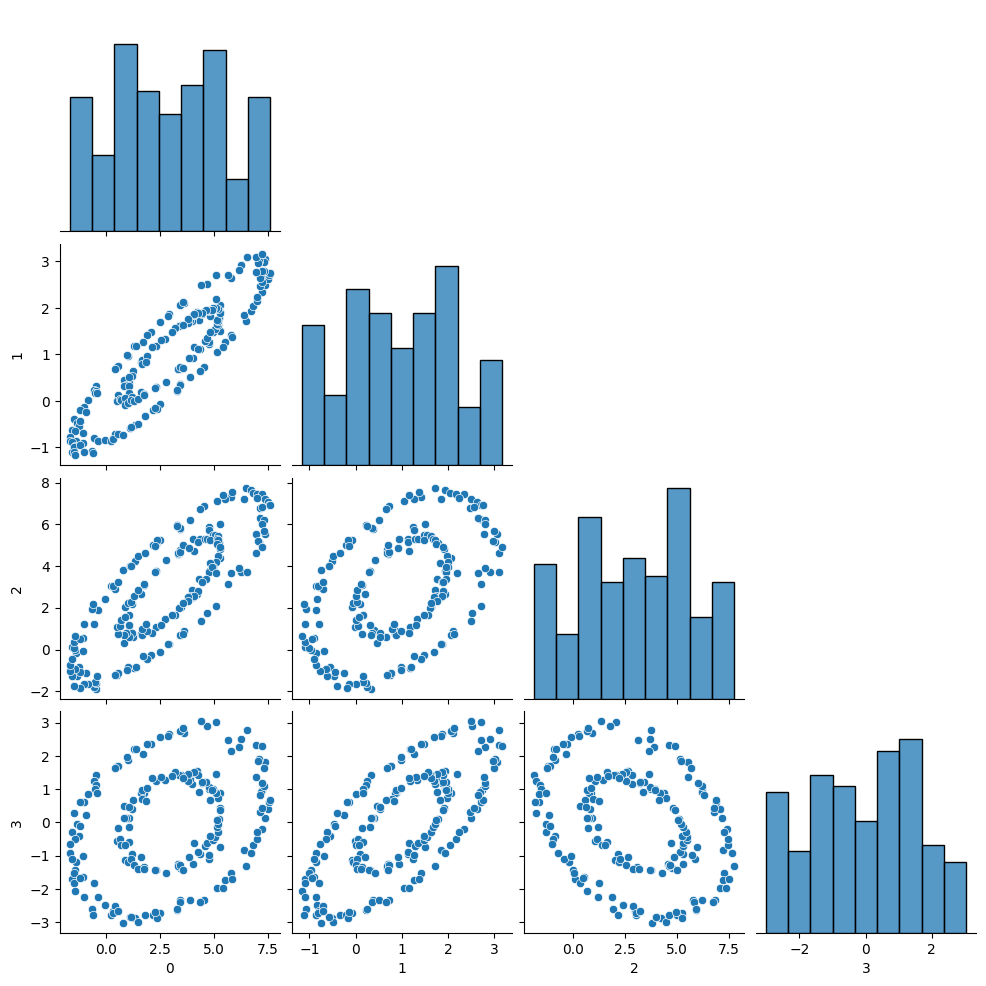

In [ ]:
#@title Анализ датасета X

df = pd.DataFrame(X)
sns.pairplot(df, corner=True)
plt.show()

> **Вывод:** точки образуют 2 эллипса в 4-ехмерном пространстве, один эллипс вложен в другой. Графики выше - проекции исходных эллипсов в двумерное пространство. **Имеется 2 четко выраженных кластера**.

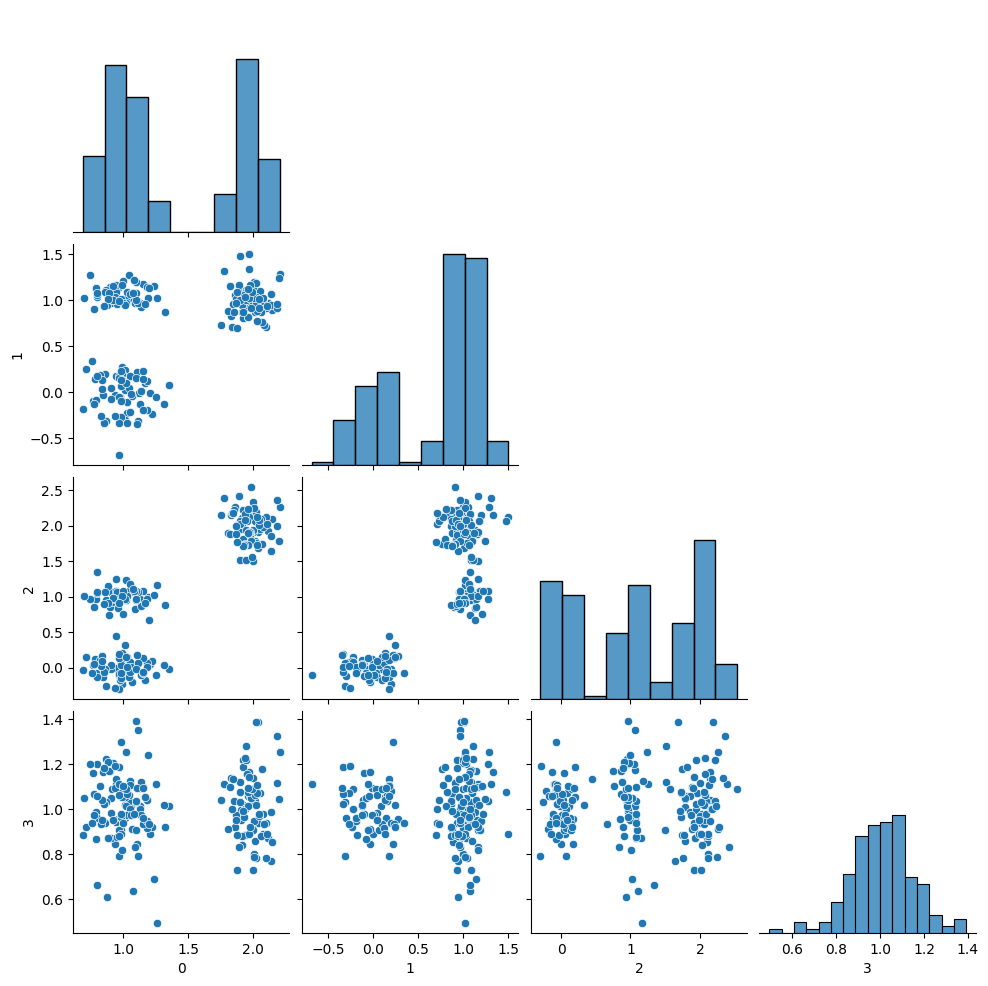

In [ ]:
#@title Анализ датасета Y

df = pd.DataFrame(Y)
sns.pairplot(df, corner=True)
plt.show()

> **Вывод:** точки образуют 3 кучные структуры, соответствующие **3 кластерам**, вероятно, с эллиптической формой распределения.

### Матрица расстояний и матрица схожести

* Для подсчета матрицы расстояний использовались: евклидова метрика и метрика Минковского при $p=3$, так как именно эти метрики обеспечивали хорошие результаты для Single Linkage и Spectral Clustering алгоритмов

In [ ]:
#@title Подсчет матрицы расстояний

# Выбор параметра p:
# p = 3 для Single Linkage
# p = 2 для Spectral Clustering
X_dist_matrix = squareform(pdist(X, 'minkowski', p=2))
Y_dist_matrix = squareform(pdist(Y, 'minkowski', p=2))

pd.DataFrame(X_dist_matrix)

0         1         2         3         4         5         6    \
0    0.000000  2.231040  2.950126  2.228011  0.908349  0.528368  0.928607   
1    2.231040  0.000000  0.902900  0.460609  2.714258  2.501815  2.930544   
2    2.950126  0.902900  0.000000  0.722294  3.240991  3.111380  3.499931   
3    2.228011  0.460609  0.722294  0.000000  2.559484  2.405193  2.806412   
4    0.908349  2.714258  3.240991  2.559484  0.000000  0.381138  0.301358   
..        ...       ...       ...       ...       ...       ...       ...   
195  0.809763  1.968675  2.823288  2.133036  1.715442  1.337373  1.728180   
196  2.703000  0.640275  1.120967  1.048801  3.285186  3.038862  3.479341   
197  1.027759  1.890461  2.768282  2.100075  1.929154  1.553312  1.950204   
198  2.736391  0.507931  0.586547  0.685102  3.183798  2.990317  3.411959   
199  0.421724  2.611149  3.283799  2.566336  0.640846  0.317373  0.553779   

          7         8         9    ...       190       191       192  \
0    2.403714  1.551366  1.744636  ...  2.394998  1.651881  3.208239   
1    0.493998  1.016081  0.957759  ...  1.780822  1.495250  1.042294   
2    0.547514  1.459809  1.294301  ...  2.609711  2.396764  1.098583   
3    0.176398  0.773442  0.641521  ...  2.209617  1.833024  1.338504   
4    2.730170  1.787894  1.946699  ...  3.254230  2.503782  3.751539   
..        ...       ...       ...  ...       ...       ...       ...   
195  2.292195  1.677403  1.858715  ...  1.630717  0.923071  2.798306   
196  1.000150  1.649841  1.598027  ...  1.560926  1.568338  0.519323   
197  2.250759  1.721416  1.892691  ...  1.408944  0.716003  2.663006   
198  0.567488  1.426812  1.318919  ...  2.041412  1.906242  0.660850   
199  2.742721  1.844427  2.031339  ...  2.800663  2.063371  3.607076   

          193       194       195       196       197       198       199  
0    3.141057  3.042951  0.809763  2.703000  1.027759  2.736391  0.421724  
1    0.995916  0.877917  1.968675  0.640275  1.890461  0.507931  2.611149  
2    1.124948  1.022458  2.823288  1.120967  2.768282  0.586547  3.283799  
3    1.315546  1.191174  2.133036  1.048801  2.100075  0.685102  2.566336  
4    3.697373  3.585158  1.715442  3.285186  1.929154  3.183798  0.640846  
..        ...       ...       ...       ...       ...       ...       ...  
195  2.720115  2.643293  0.000000  2.279107  0.224365  2.463422  1.185982  
196  0.443341  0.366927  2.279107  0.000000  2.146026  0.536250  3.107185  
197  2.582474  2.512560  0.224365  2.146026  0.000000  2.371877  1.409818  
198  0.649925  0.527633  2.463422  0.536250  2.371877  0.000000  3.111626  
199  3.542135  3.440973  1.185982  3.107185  1.409818  3.111626  0.000000  

[200 rows x 200 columns]

Формула подсчета схожести:

$$similarity(x, y) = \frac{\exp(-d(x, y)^2)}{2\sigma^2} $$

* Параметр $\sigma$ подбирался для каждого датасета отдельно. Для успешной кластеризации датасета X с двумя эллипсами, значения параметра $\sigma$ требуется достаточно маленьким, чтобы бОльший упор был на локальном поиске (окрестности точек)

In [ ]:
#@title Подсчет оптимальных параметров $\sigma_x$ и $\sigma_y$

# Медиана расстояний до 2-ого ближайшего соседа
sigma_x = np.median(np.sort(X_dist_matrix, axis=-1)[:,2]).item()
sigma_y = np.median(np.sort(Y_dist_matrix, axis=-1)[:,2]).item()

print(f'sigma_x = {sigma_x}, sigma_y = {sigma_y}')

sigma_x = 0.3652567693122651, sigma_y = 0.15301062532816315


In [ ]:
#@title Подсчет матрицы близости

X_similarity_matrix = np.exp(- X_dist_matrix ** 2 / (2 * sigma_x ** 2))  # 1.0 / (1.0 + X_dist_matrix)
Y_similarity_matrix = np.exp(- Y_dist_matrix ** 2 / (2 * sigma_y ** 2))  # 1.0 / (1.0 + Y_dist_matrix)

pd.DataFrame(X_similarity_matrix)

0             1             2             3             4    \
0    1.000000e+00  7.913502e-09  6.827737e-15  8.324390e-09  4.539831e-02   
1    7.913502e-09  1.000000e+00  4.710906e-02  4.515226e-01  1.020648e-12   
2    6.827737e-15  4.710906e-02  1.000000e+00  1.415297e-01  8.003139e-18   
3    8.324390e-09  4.515226e-01  1.415297e-01  1.000000e+00  2.174766e-11   
4    4.539831e-02  1.020648e-12  8.003139e-18  2.174766e-11  1.000000e+00   
..            ...           ...           ...           ...           ...   
195  8.565085e-02  4.918099e-07  1.062121e-13  3.931024e-08  1.622863e-05   
196  1.282734e-12  2.151523e-01  9.010837e-03  1.620411e-02  2.715254e-18   
197  1.908730e-02  1.524320e-06  3.363445e-13  6.631363e-08  8.760400e-07   
198  6.494097e-13  3.802595e-01  2.754430e-01  1.722042e-01  3.171985e-17   
199  5.134786e-01  7.991018e-12  2.809556e-18  1.906527e-11  2.145637e-01   

              5             6             7         8             9    ...  \
0    3.512434e-01  3.948844e-02  3.942488e-10  0.000121  1.111394e-05  ...   
1    6.493654e-11  1.051243e-14  4.006834e-01  0.020873  3.213406e-02  ...   
2    1.751242e-16  1.154052e-20  3.251475e-01  0.000340  1.876539e-03  ...   
3    3.838760e-10  1.516393e-13  8.899259e-01  0.106249  2.138689e-01  ...   
4    5.801756e-01  7.115137e-01  7.376825e-13  0.000006  6.789560e-07  ...   
..            ...           ...           ...       ...           ...  ...   
195  1.227049e-03  1.376858e-05  2.806286e-09  0.000026  2.381245e-06  ...   
196  9.317089e-16  1.977526e-20  2.354365e-02  0.000037  6.974573e-05  ...   
197  1.182694e-04  6.450746e-07  5.682289e-09  0.000015  1.476889e-06  ...   
198  2.790414e-15  1.126979e-19  2.991098e-01  0.000486  1.474506e-03  ...   
199  6.855746e-01  3.168480e-01  5.702537e-13  0.000003  1.922280e-07  ...   

              190           191           192           193           194  \
0    4.611557e-10  3.619494e-05  1.766243e-17  8.736568e-17  8.488041e-16   
1    6.890127e-06  2.296013e-04  1.705191e-02  2.430139e-02  5.565682e-02   
2    8.219140e-12  4.467601e-10  1.085502e-02  8.713875e-03  1.988075e-02   
3    1.130341e-08  3.397600e-06  1.213211e-03  1.524441e-03  4.904009e-03   
4    5.798270e-18  6.258391e-11  1.237506e-23  5.613890e-23  1.200571e-21   
..            ...           ...           ...           ...           ...   
195  4.695957e-05  4.103492e-02  1.797849e-13  9.058760e-13  4.243228e-12   
196  1.082127e-04  9.920322e-05  3.639417e-01  4.787241e-01  6.037573e-01   
197  5.874081e-04  1.464112e-01  2.867097e-12  1.396368e-11  5.306262e-11   
198  1.648315e-07  1.217742e-06  1.946136e-01  2.053442e-01  3.522665e-01   
199  1.711103e-13  1.175797e-07  6.649756e-22  3.788683e-21  5.349131e-20   

              195           196           197           198           199  
0    8.565085e-02  1.282734e-12  1.908730e-02  6.494097e-13  5.134786e-01  
1    4.918099e-07  2.151523e-01  1.524320e-06  3.802595e-01  7.991018e-12  
2    1.062121e-13  9.010837e-03  3.363445e-13  2.754430e-01  2.809556e-18  
3    3.931024e-08  1.620411e-02  6.631363e-08  1.722042e-01  1.906527e-11  
4    1.622863e-05  2.715254e-18  8.760400e-07  3.171985e-17  2.145637e-01  
..            ...           ...           ...           ...           ...  
195  1.000000e+00  3.511682e-09  8.280669e-01  1.326670e-10  5.136179e-03  
196  3.511682e-09  1.000000e+00  3.191779e-08  3.403684e-01  1.931106e-16  
197  8.280669e-01  3.191779e-08  1.000000e+00  6.970025e-10  5.820089e-04  
198  1.326670e-10  3.403684e-01  6.970025e-10  1.000000e+00  1.741257e-16  
199  5.136179e-03  1.931106e-16  5.820089e-04  1.741257e-16  1.000000e+00  

[200 rows x 200 columns]

### Построение графовой модели, визуализация графа

In [ ]:
#@title Построение графовой модели

def build_graph_model(similarity_matrix):
  G = nx.Graph()
  G.add_nodes_from(range(X.shape[0]))
  V = X.shape[0]

  edges_data = []
  for i in range(V):
    for j in range(i + 1, V):
      weight = similarity_matrix[i, j]
      edges_data.append((i, j, weight))

  G.add_weighted_edges_from(edges_data)

  return G

X_graph_model = build_graph_model(X_similarity_matrix)
Y_graph_model = build_graph_model(Y_similarity_matrix)

X_graph_model.number_of_edges(), Y_graph_model.number_of_edges()

(19900, 19900)

In [ ]:
#@title Построение максимального остовного дерева

def MST(G):
  G_inv = G.copy()
  # Инвертируем веса: максимальное MST -> минимальное MST с инвертированными весами
  for u, v in G_inv.edges():
    weight = G_inv[u][v].get('weight', 1)
    G_inv[u][v]['weight'] = 1.0 / (weight + 1e-10)

  mst_edges = list(nx.minimum_spanning_edges(G_inv, data=True, algorithm='kruskal'))

  MST = nx.Graph()
  MST.add_nodes_from(G.nodes(data=True))

  for u, v, data in mst_edges:
    original_weight = G[u][v].get('weight', 1)
    MST.add_edge(u, v, weight=original_weight)

  return MST


X_MST_graph = MST(X_graph_model)
Y_MST_graph = MST(Y_graph_model)

X_MST_graph.number_of_edges(), Y_MST_graph.number_of_edges()

(199, 199)

* Вместо построения исходного графа будем строить **MST** - связность графа сохраняется, а за счет небольшого числа ребер все будет хорошо видно, и ничего не сольется в кашу

* Воспользуемся **PCA**, чтобы спроецировать объекты исходных выборок в двумерное пространство. При отрисовке MST вершины графа будут расположены в соответствии с результатами PCA.  

* Но для этого нужно проверить, что PCA не ломает исходные зависимости. Например, для датасета X мы ожидаем увидеть 2 вложенных эллипса.

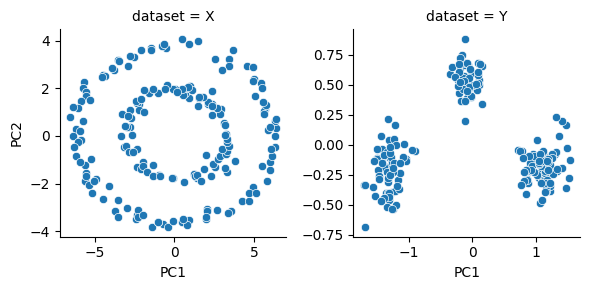

In [ ]:
# Вызов PCA

X_pca = PCA(n_components=2).fit_transform(X)
Y_pca = PCA(n_components=2).fit_transform(Y)

df = pd.DataFrame(columns=['PC1', 'PC2', 'dataset'])
df['PC1'] = np.concatenate((X_pca[:,0], Y_pca[:,0]))
df['PC2'] = np.concatenate((X_pca[:,1], Y_pca[:,1]))
df['dataset'] = (200 * ['X']) + (200 * ['Y'])

g = sns.FacetGrid(df, col='dataset', sharex=False, sharey=False)
g.map(sns.scatterplot, "PC1", "PC2")
plt.show()

> **Вывод:** после вызова **PCA** структура кластеров не изменилась

In [ ]:
#@title Метод визуализация графа

COLORS = np.array(['green', 'red', 'yellow'])

def draw_weighted_graph(G, clusters=None, figsize=(16, 12), layout='spring',
                   show_labels='central', max_labels=50, positions=None, title=""):
    # fig, axes = plt.subplots(1, 2, figsize=figsize,
    #                         gridspec_kw={'width_ratios': [3, 1]})
    plt.figure(figsize=(16, 12))

    if layout == 'hierarchical':
        # Для деревьев используем иерархический layout
        if nx.is_tree(G):
            # Определяем корень (вершина с максимальной центральностью)
            centrality = nx.degree_centrality(G)
            root = max(centrality, key=centrality.get)
            pos = nx.nx_agraph.graphviz_layout(G, prog='dot', root=root)
        else:
            # Для неточных деревьев используем spring с настройками
            pos = nx.spring_layout(G, seed=35353, k=5/np.sqrt(G.order()),
                                iterations=100)

    elif layout == 'custom': # требуется positions != None
        pos = {i: positions[i] for i in G.nodes}

    else:  # 'spring'
        # Стандартный с настройками для больших графов
        k = 3 / np.sqrt(G.order())  # параметр отталкивания
        pos = nx.spring_layout(G, seed=35353, k=k, iterations=200)

    if clusters is None:
        # Окрашивание по степеням графа
        degrees = dict(G.degree())
        node_colors = [degrees[node] for node in G.nodes()]
    else:
        # Окрашивание по заранее известным кластерам графа
        selection = np.array(clusters - 1, int)
        node_colors = COLORS[selection]

    nodes = nx.draw_networkx_nodes(
        G, pos,
        node_size=80,
        node_color=node_colors,
        edgecolors='black',
        linewidths=0.5,
        alpha=0.9
    )

    if G.number_of_edges() > 0:
        edges = list(G.edges())
        weights = [G[u][v].get('weight', 1) for u, v in edges]

    if len(set(weights)) > 1:
        # Используем логарифмическую шкалу для больших различий
        log_weights = np.log1p(weights)
        min_w, max_w = log_weights.min(), log_weights.max()
        if max_w > min_w:
            widths = [0.5 + 4 * (w - min_w) / (max_w - min_w) for w in log_weights]
        else:
            widths = [2] * len(weights)
    else:
        widths = [1] * len(edges)

    edge_vmin, edge_vmax = min(weights), max(weights)

    edges_draw = nx.draw_networkx_edges(
        G, pos,
        width=widths,
        edge_color="grey",
        edge_vmin=edge_vmin,
        edge_vmax=edge_vmax,
        alpha=0.6
    )

    # 3. Подписи вершин (только важные)
    if show_labels != 'none':
        labels_to_show = {}

        if show_labels == 'central':
            # Только вершины с высокой центральностью
            centrality = nx.betweenness_centrality(G)
            top_nodes = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:max_labels]
            for node, _ in top_nodes:
                labels_to_show[node] = str(node)

        elif show_labels == 'degree':
            # Вершины со степенью выше среднего
            avg_degree = np.mean(list(degrees.values()))
            for node in G.nodes():
                if degrees[node] > avg_degree:
                    labels_to_show[node] = str(node)
                    if len(labels_to_show) >= max_labels:
                        break

        elif show_labels == 'all':
            # Все вершины (осторожно!)
            if G.order() <= 100:
                labels_to_show = {node: str(node) for node in G.nodes()}
            else:
                # Каждая 5-я вершина
                for i, node in enumerate(G.nodes()):
                    if i % 5 == 0:
                        labels_to_show[node] = str(node)

        if labels_to_show:
            nx.draw_networkx_labels(
                G, pos,
                labels=labels_to_show,
                font_size=8,
                font_weight='bold',
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=1)
            )

    plt.title(f"Граф: {G.number_of_nodes()} узлов, {G.number_of_edges()} ребер\n"
                        f"{title}",
                        fontsize=12)

    plt.axis('off')
    plt.tight_layout()
    plt.show()

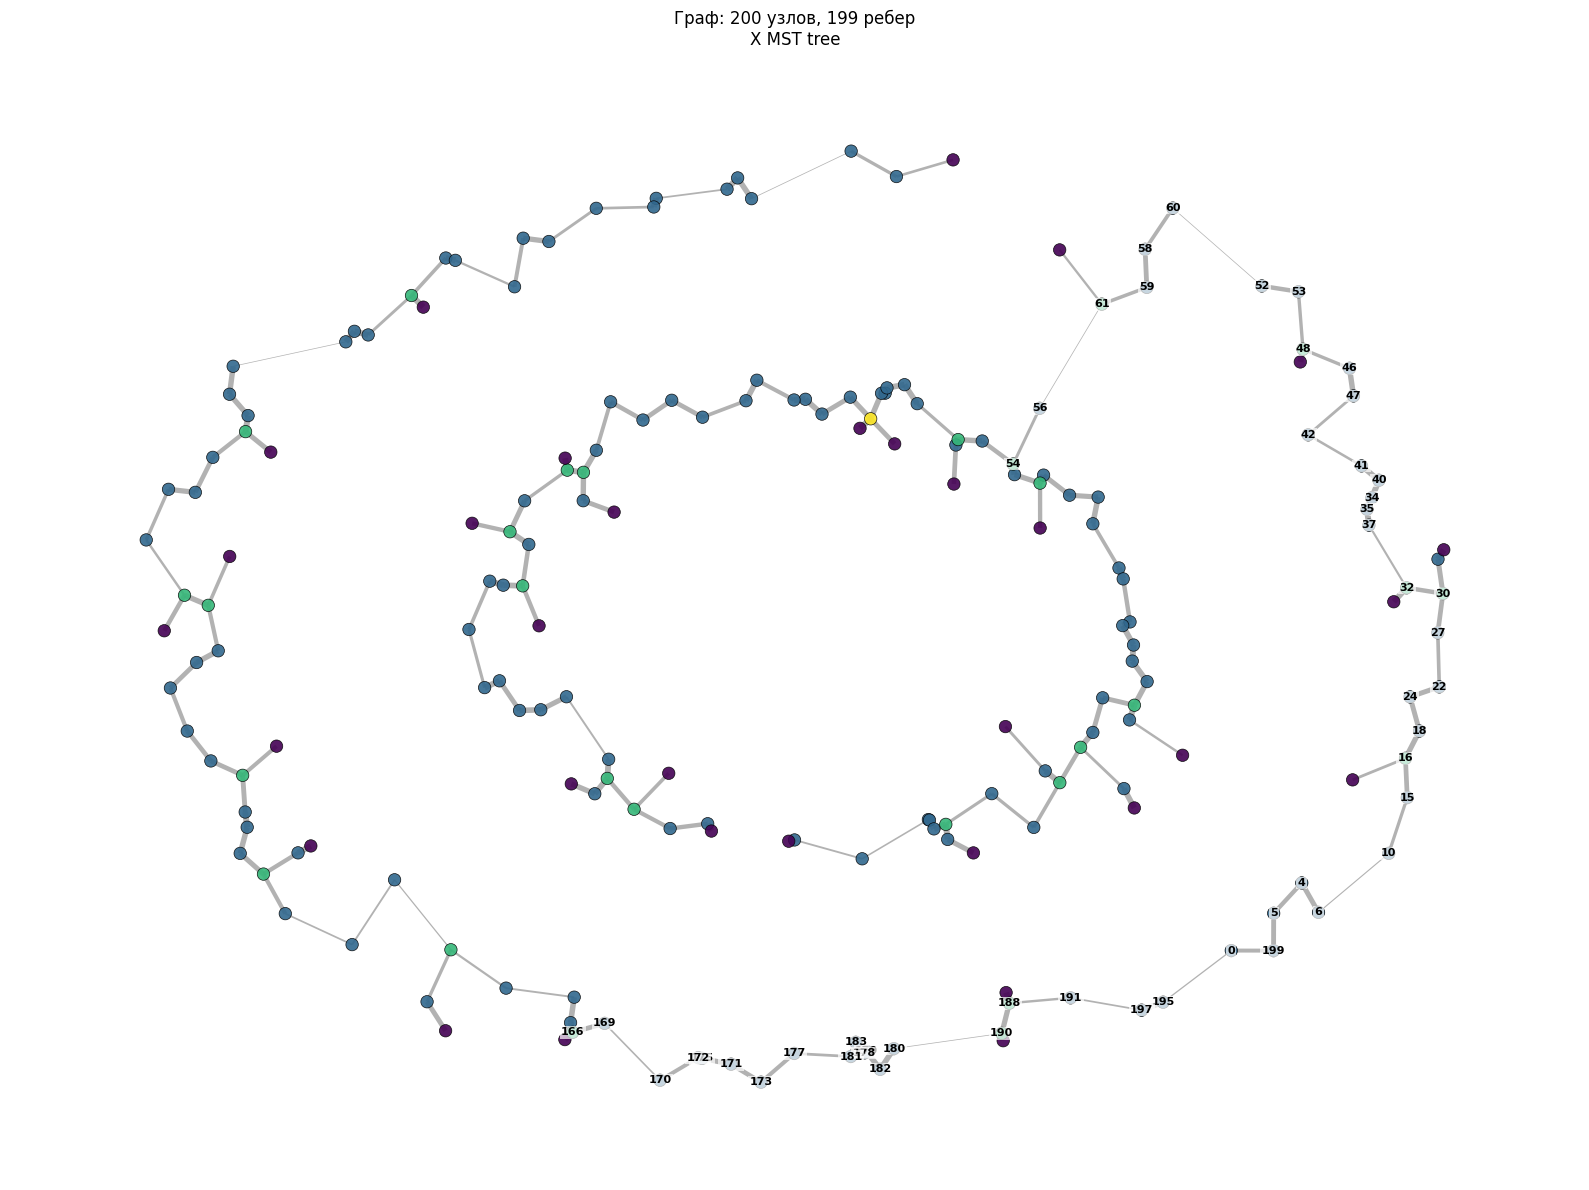

In [ ]:
#@title Визуализация X

draw_weighted_graph(X_MST_graph, layout='custom', show_labels='central', positions=X_pca, title="X MST tree")

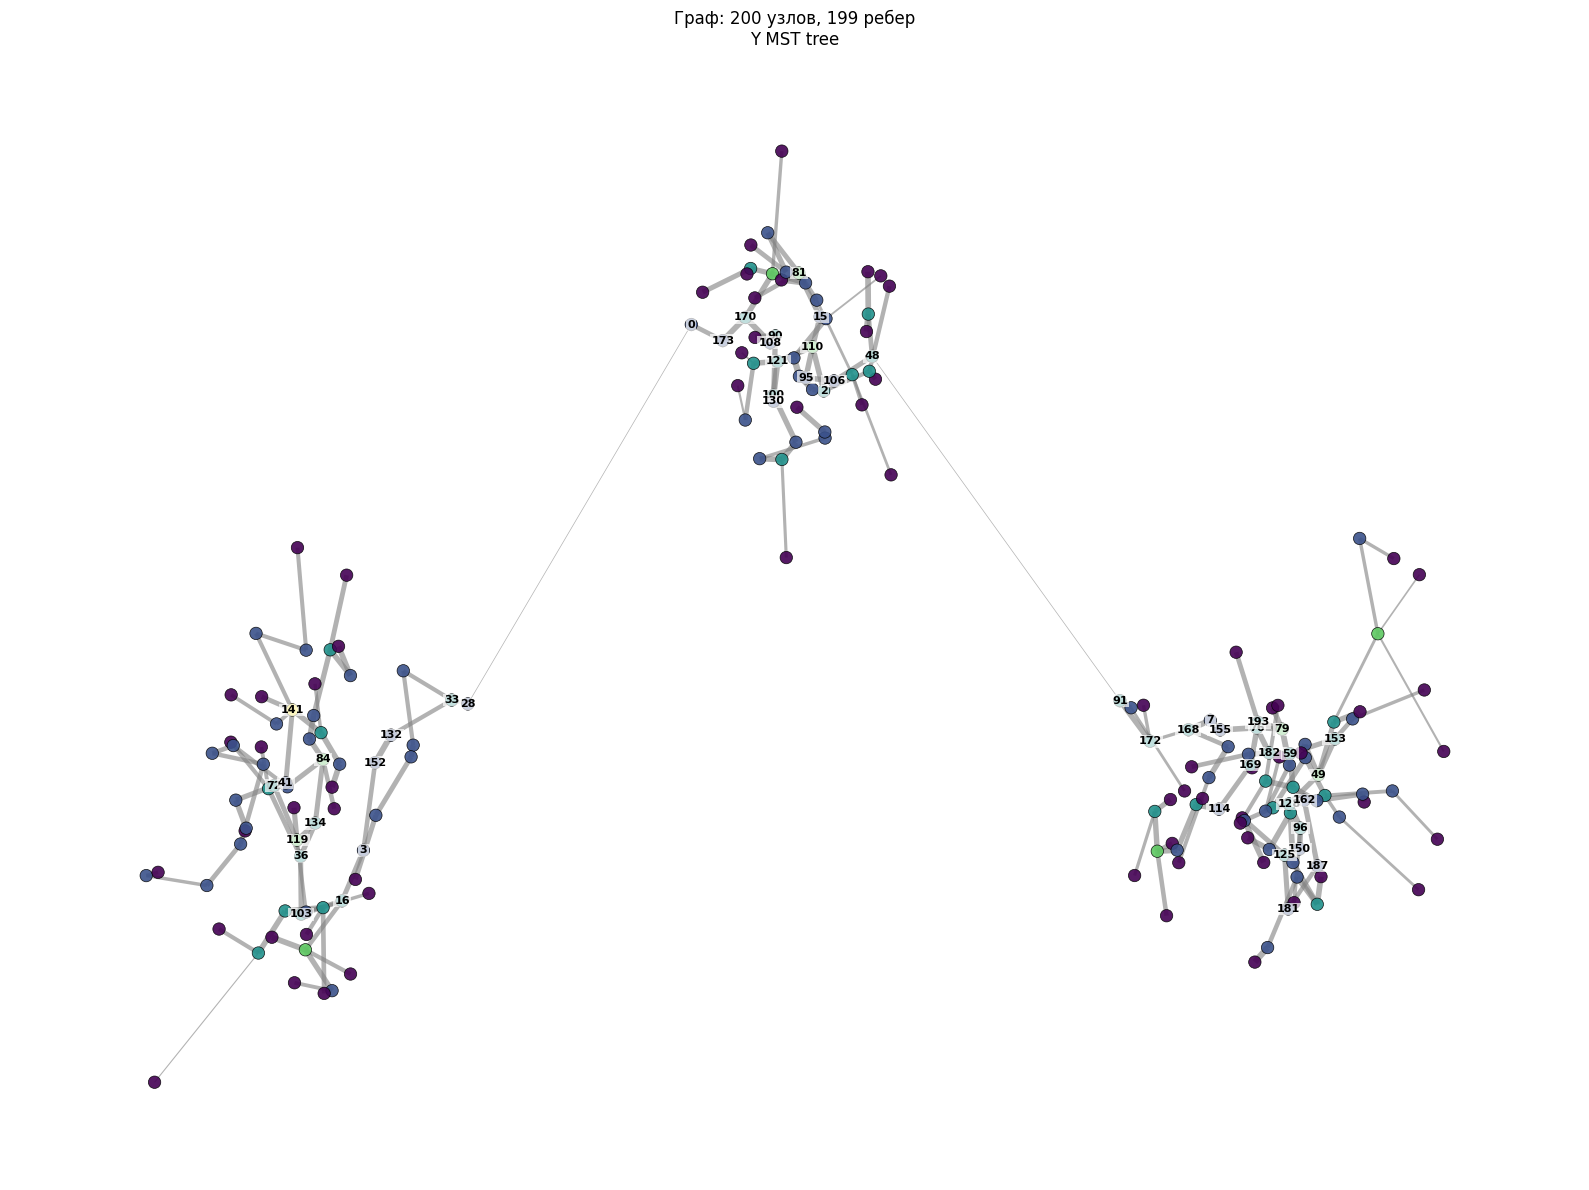

In [ ]:
#@title Визуализация Y

draw_weighted_graph(Y_MST_graph, layout='custom', show_labels='central', positions=Y_pca, title="Y MST tree")

## Кластеризация для числа кластеров $k=2$

### Single и Centroid Linkage кластеризация

* Лучший Linkage для датасета X - Single Linkage. Чтобы получить приемлимый результат, мы должны смотреть на ближайших соседей. В противном случае, если расстояния усреднять, алгоритм будет искать кластеры в виде куч (точек внутри круга). Подходящая метрика: метрика Минковского с $p=3$

[2 1 1 1 2 2 2 1 1 1 2 1 1 2 1 2 2 1 2 1 1 1 2 1 2 1 1 2 1 2 2 2 2 2 2 2 1
 2 1 1 2 2 2 1 1 1 2 2 2 2 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 2 2 2 1 1 1 2 2 2 1 1 2 2 1 1 1 1 2 2 2 2 2 1 1 1 2 2 1 2 1 2 2 2 1 1 2 2
 1 2 2 2 2 1 1 1 1 2 2 2 2 1 2 2 2 2 1 2 2 1 1 2 1 1 2 2 2 2 1 2 2 2 1 2 2
 1 2 1 2 1 2 1 1 1 2 2 2 1 2 2 2 2 1 2 1 1 2 2 2 2 2 1 2 1 2 2 2 2 2 2 2 1
 2 2 1 2 1 2 2 1 1 1 2 1 2 1 2]


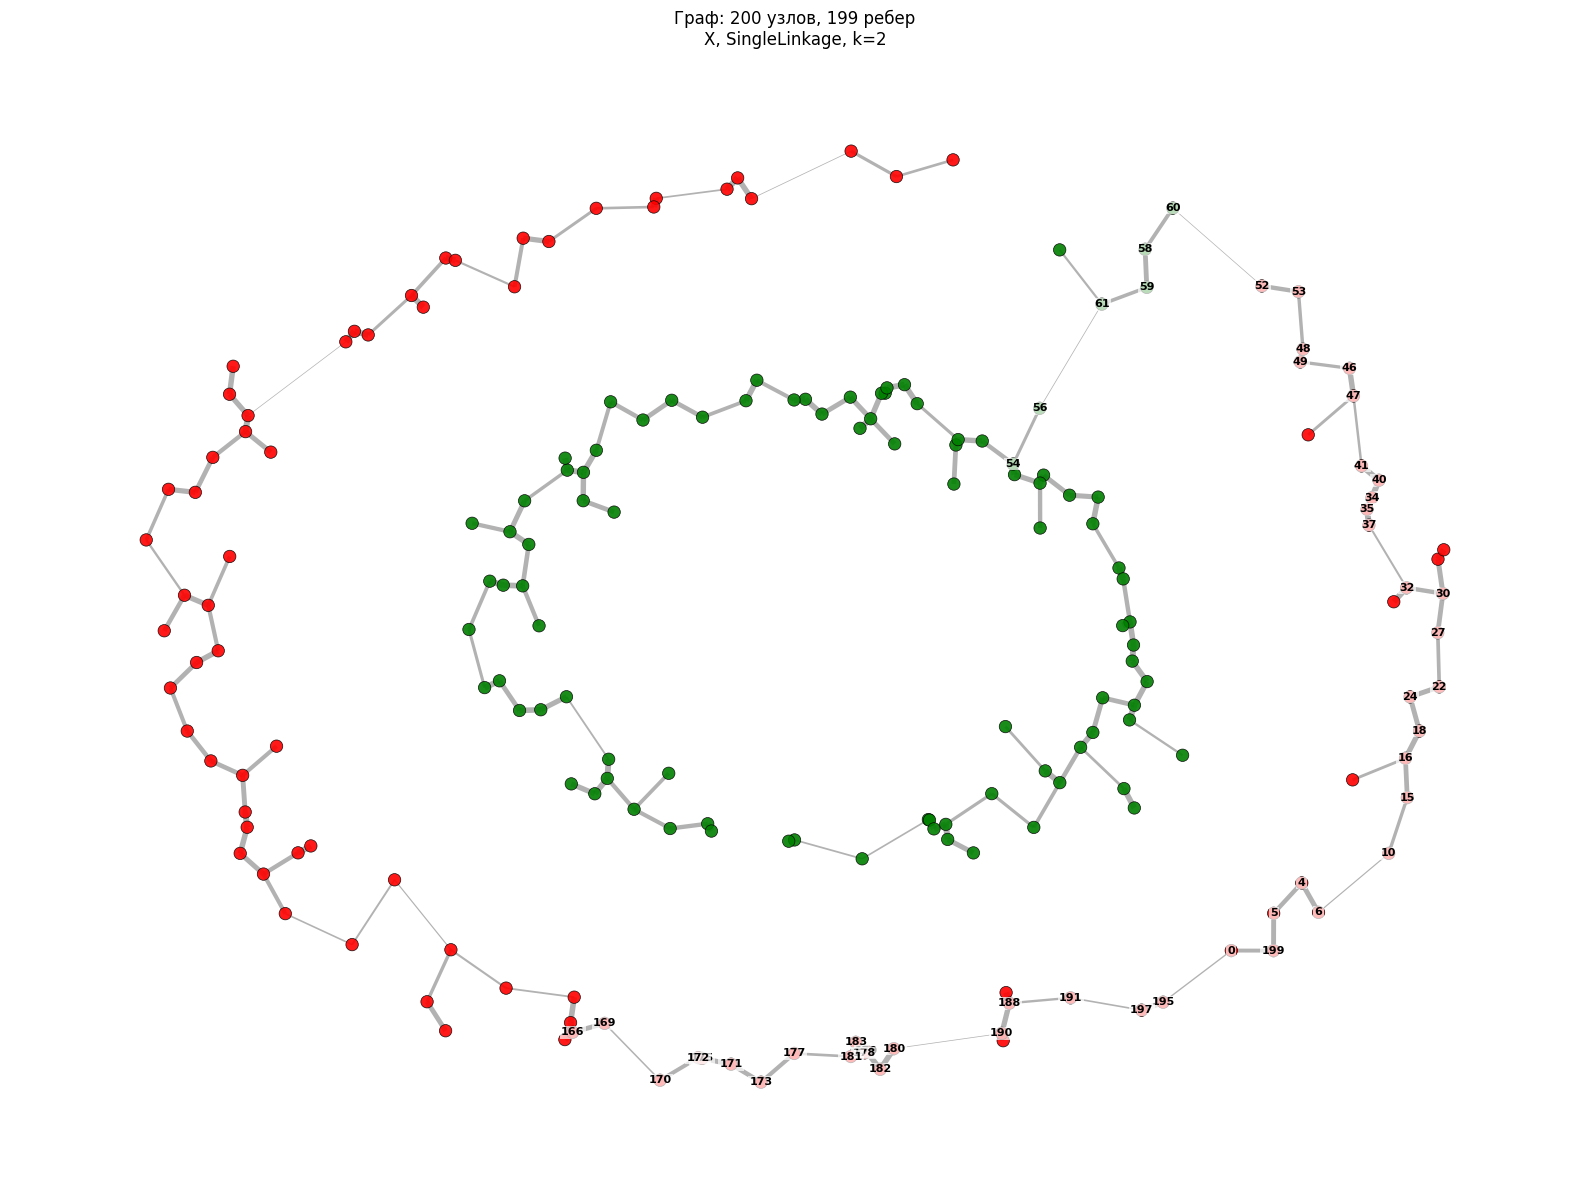

In [ ]:
#@title Кластеризация датасета X (Single Linkage)

condensed_dist_matrix = squareform(X_dist_matrix)
Z = linkage(condensed_dist_matrix, method='single')
SL_labels_x = fcluster(Z, t=2, criterion='maxclust')
print(SL_labels_x)

draw_weighted_graph(X_MST_graph, clusters=SL_labels_x, layout='custom', positions=X_pca, title="X, SingleLinkage, k=2")

> **Вывод:** 5 точек из внешнего эллипса вошли в кластерную структуру внутреннего эллипса из-за малого числа данных. Глазами можно увидеть кластерную структуру, однако по картинке выше мы видим **слабые связи между некоторыми вершинами, находящимся во внешнем эллипсе**, из-за чего алгоритм вплоть до последних шагов разбивает внешний эллипс на несколько кластеров, причем расстояние между этими кластерами примерно такое же, как и расстояние до кластера внутреннего эллипса, что усложняет задачу определения кластеров как двух эллипсов.

[2 2 2 2 2 1 2 1 2 2 2 1 1 1 1 2 2 2 2 2 1 1 1 1 2 2 1 2 2 2 2 1 2 2 2 2 2
 2 1 2 1 2 2 1 2 2 2 2 2 1 2 1 1 2 2 1 2 2 1 1 2 2 1 1 1 1 2 1 1 1 1 2 2 2
 1 2 1 2 1 1 2 2 1 2 2 1 2 2 2 2 2 1 2 2 2 2 1 1 1 2 2 2 2 2 2 2 2 1 2 2 2
 2 1 2 1 2 1 2 1 2 1 2 1 2 1 1 2 2 1 2 2 1 2 2 2 1 1 2 2 2 1 2 1 2 2 1 1 2
 1 1 1 1 2 1 1 1 2 1 2 2 2 2 1 1 2 2 2 1 1 1 2 1 1 2 2 2 2 2 2 2 2 1 1 2 1
 1 2 1 1 2 2 2 2 1 1 1 1 1 2 2]


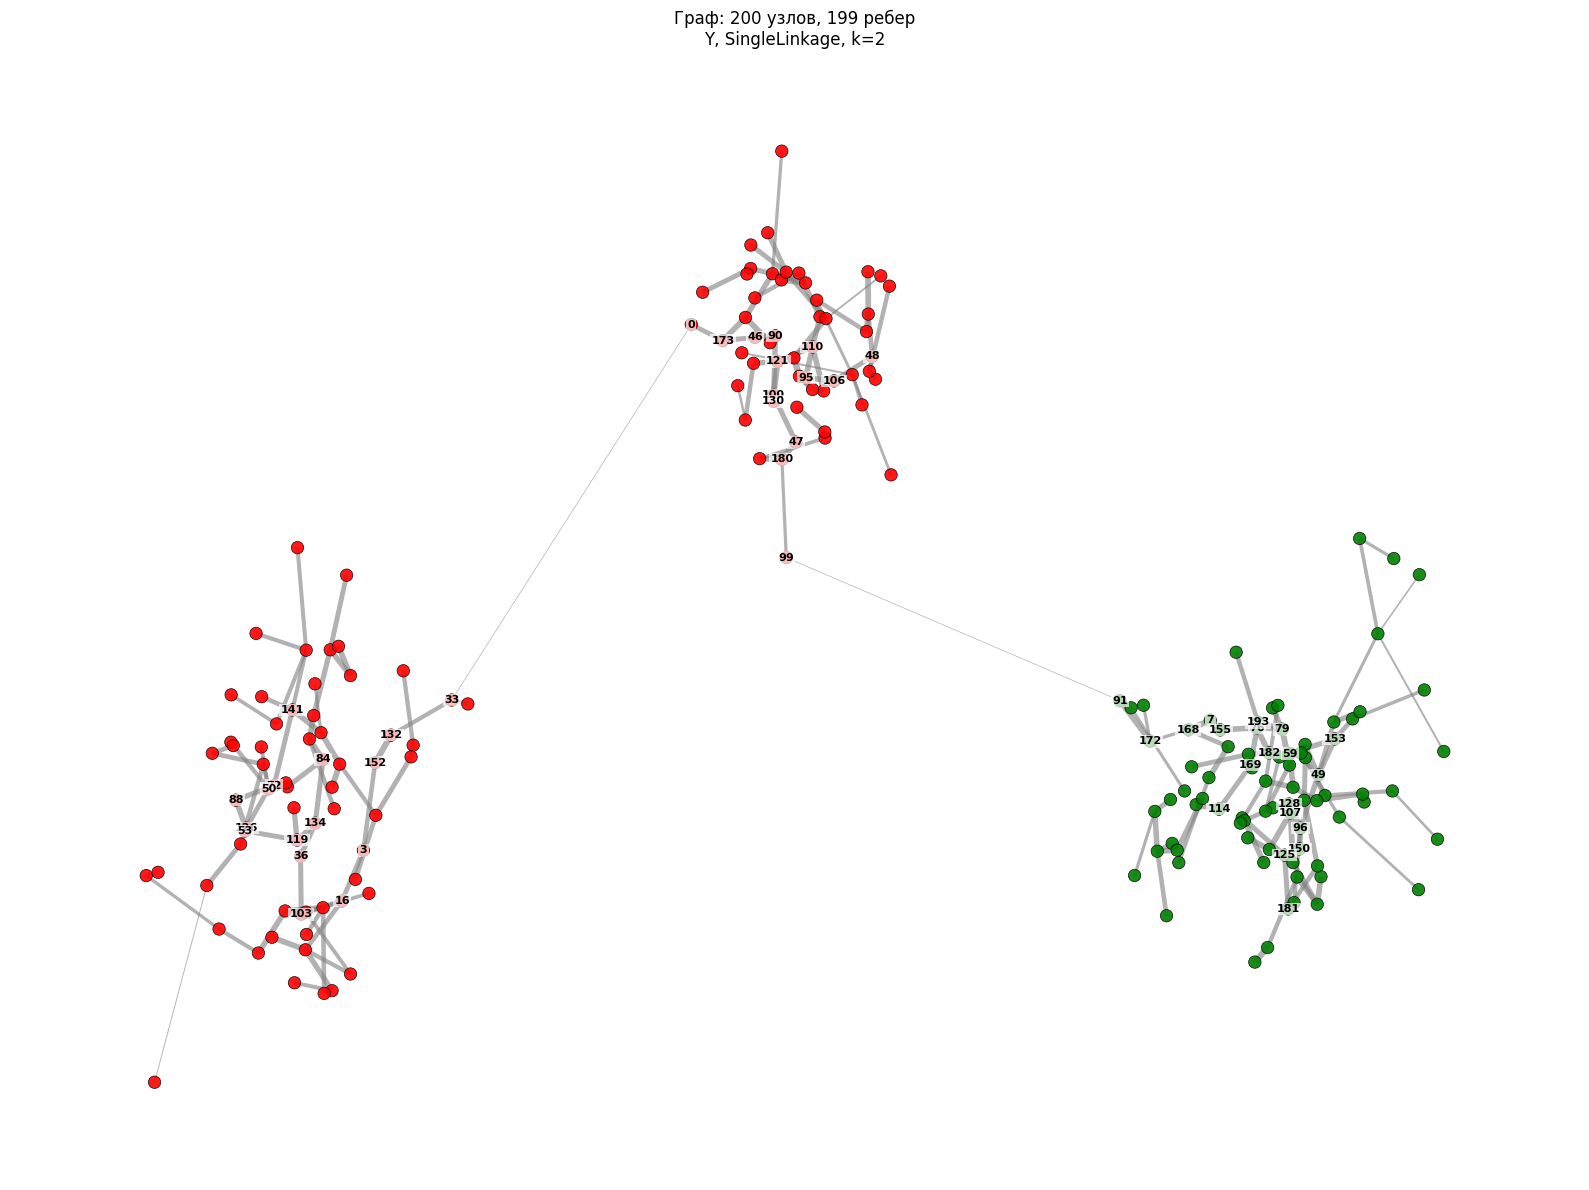

In [ ]:
#@title Кластеризация датасета Y (SingleLinkage)

condensed_dist_matrix = squareform(Y_dist_matrix)
Z = linkage(condensed_dist_matrix, method='single')
SL_labels_y = fcluster(Z, t=2, criterion='maxclust')
print(SL_labels_y)

draw_weighted_graph(Y_MST_graph, clusters=SL_labels_y, layout='custom', positions=Y_pca, title="Y, SingleLinkage, k=2")

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


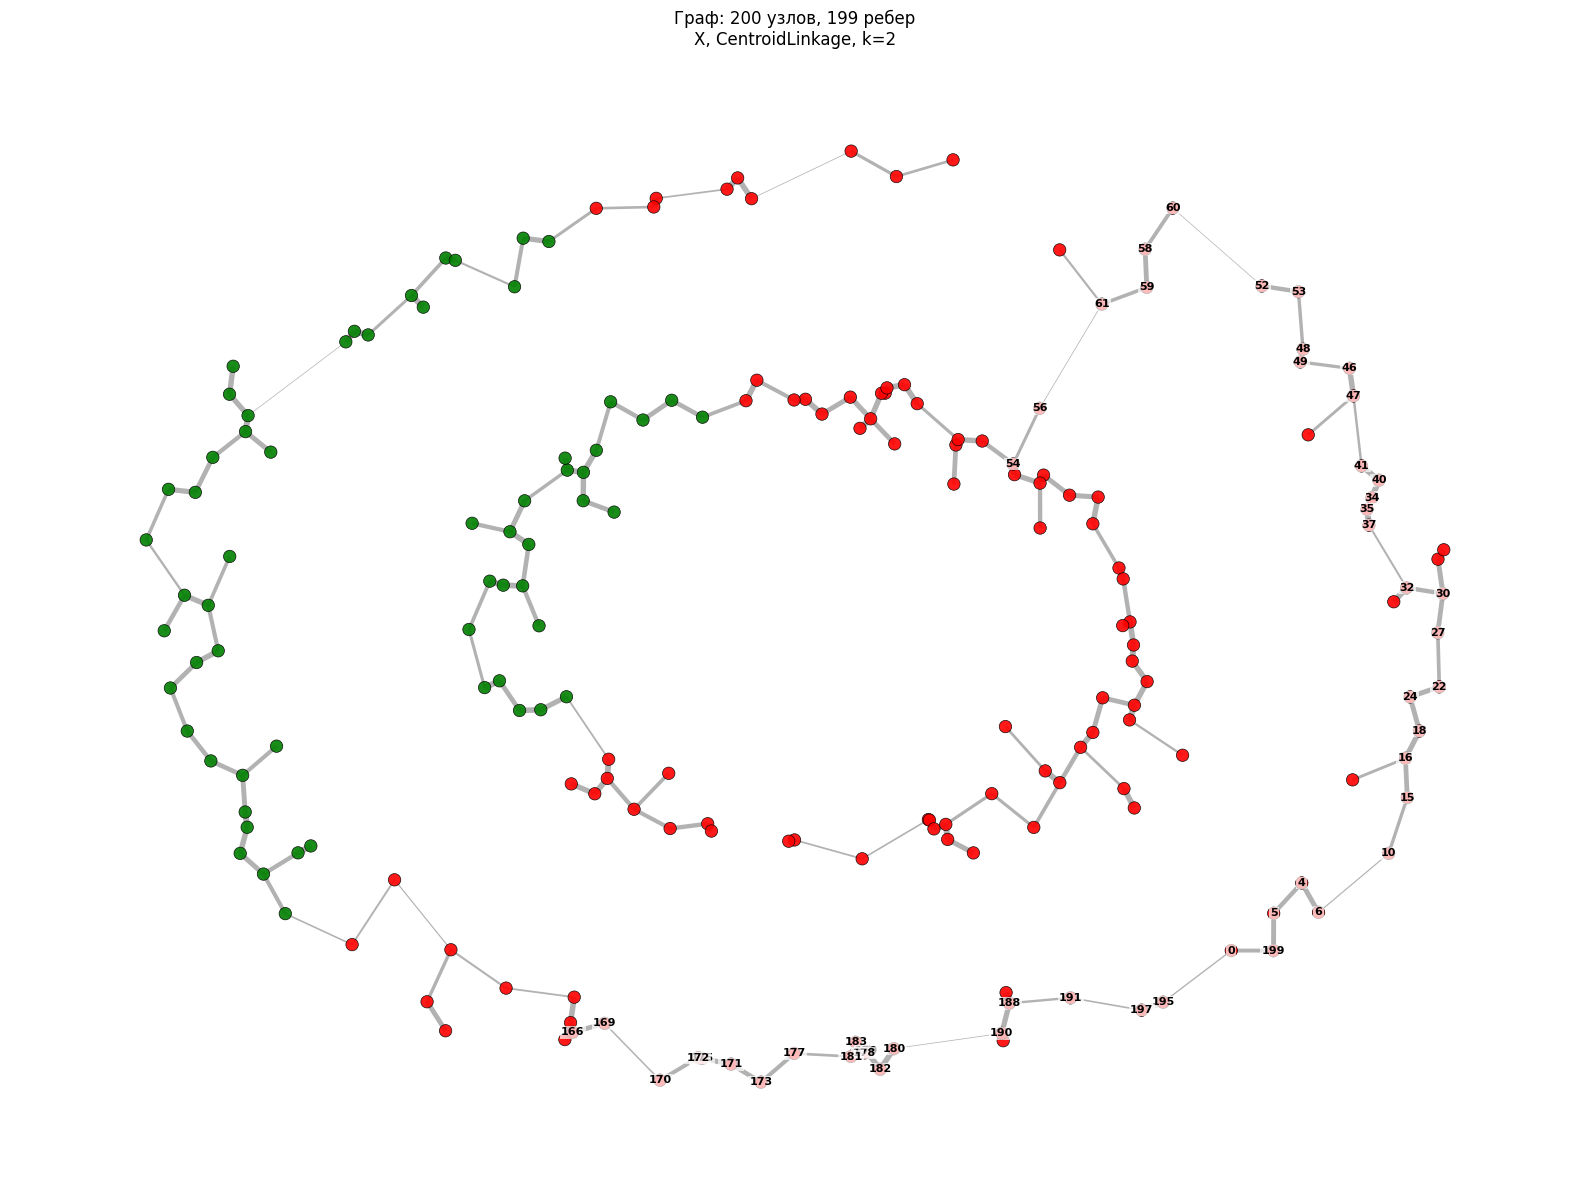

In [ ]:
#@title Кластеризация датасета X (CentroidLinkage)

def CentroidLinkage(dist_matrix, n_clusters = 2):
  condensed_dist_matrix = squareform(dist_matrix)
  Z = linkage(condensed_dist_matrix, method='centroid')
  labels = fcluster(Z, t=n_clusters, criterion='maxclust')
  print(labels)
  return labels

CL_labels_x = CentroidLinkage(X_dist_matrix)

draw_weighted_graph(X_MST_graph, clusters=CL_labels_x, layout='custom', positions=X_pca, title="X, CentroidLinkage, k=2")

[2 1 2 1 2 2 2 2 2 2 1 2 2 2 2 2 1 1 1 1 2 2 2 2 2 2 2 2 1 1 2 2 2 1 1 2 1
 2 2 1 2 1 1 2 2 2 2 2 2 2 1 2 2 1 1 2 1 1 2 2 2 2 2 2 2 2 1 2 2 2 2 2 1 1
 2 1 2 1 2 2 2 2 2 1 1 2 2 1 1 1 2 2 1 1 2 2 2 2 2 2 2 1 1 1 2 2 2 2 2 1 2
 2 2 1 2 2 2 2 2 1 2 2 2 2 2 2 1 1 2 1 2 2 1 1 1 2 2 1 2 1 2 1 2 1 1 2 2 1
 2 2 2 2 1 2 2 2 1 2 1 1 1 2 2 2 2 2 1 2 2 2 2 2 2 2 1 1 2 1 2 1 2 2 2 1 2
 2 1 2 2 1 2 1 2 2 2 2 2 2 1 2]


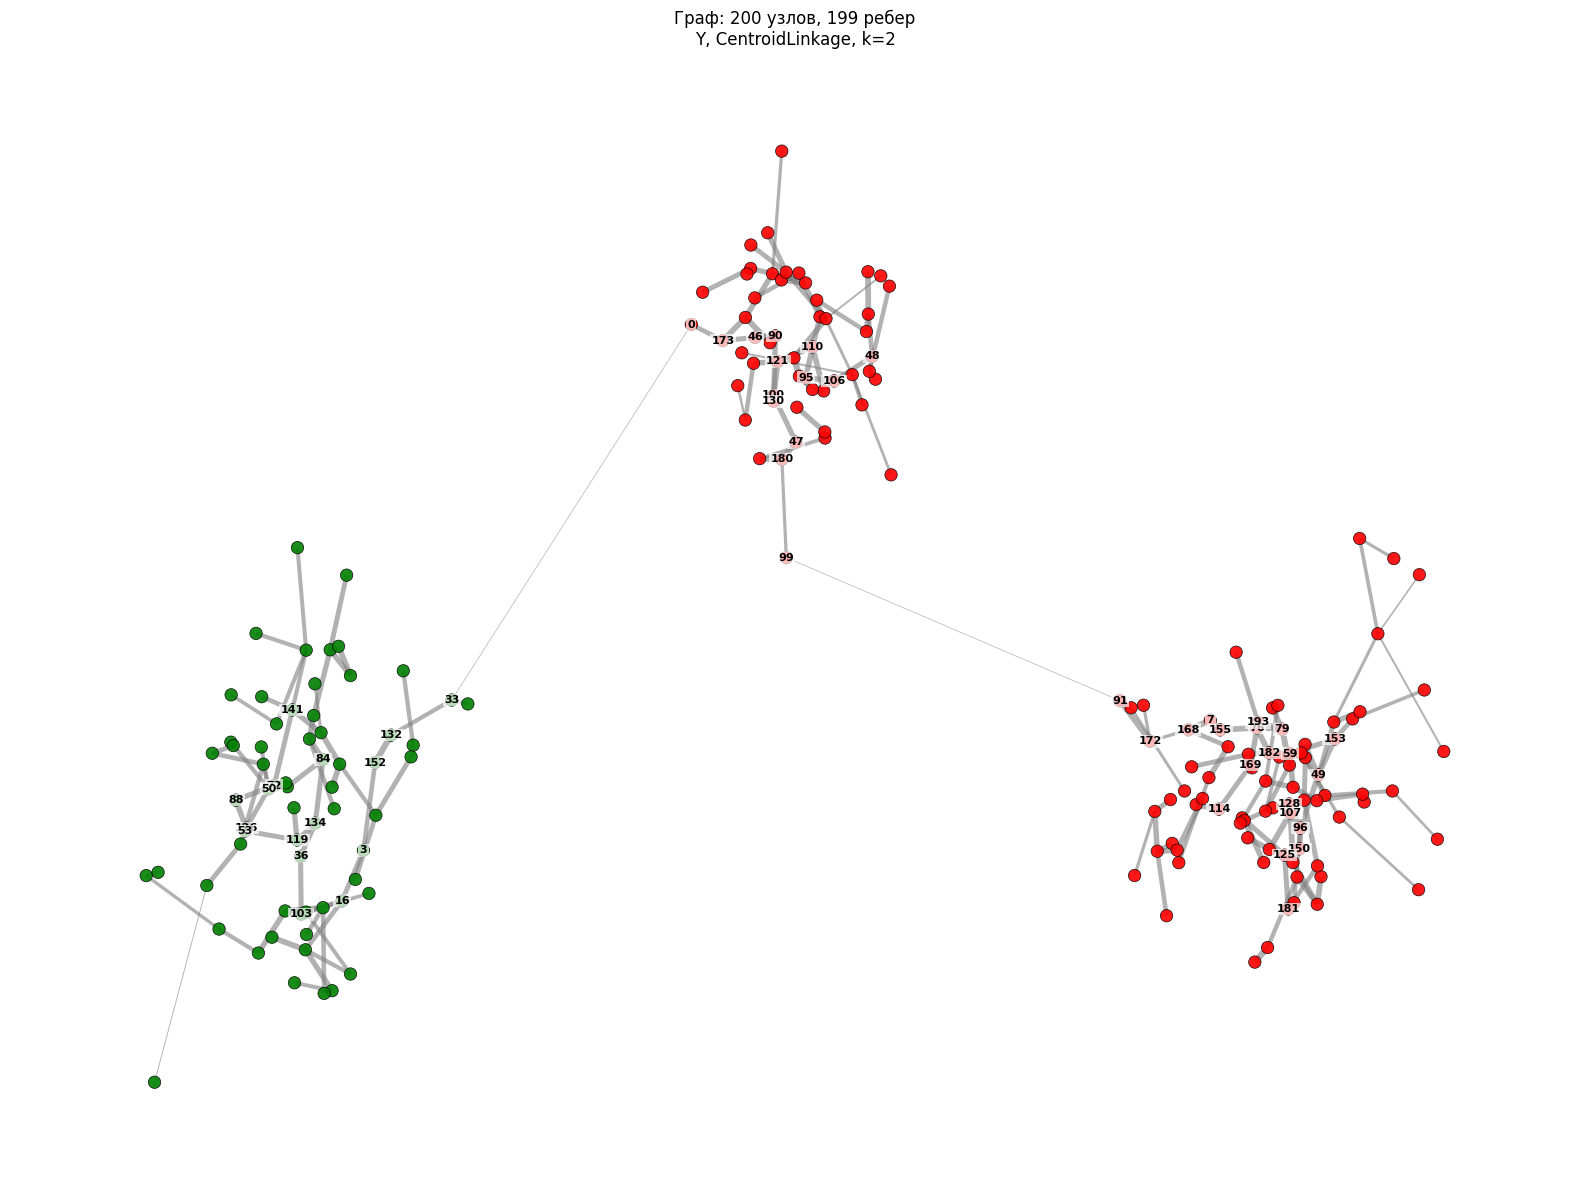

In [ ]:
#@title Кластеризация датасета Y (CentroidLinkage)

def CentroidLinkage(dist_matrix, n_clusters = 2):
  condensed_dist_matrix = squareform(dist_matrix)
  Z = linkage(condensed_dist_matrix, method='centroid')
  labels = fcluster(Z, t=n_clusters, criterion='maxclust')
  print(labels)
  return labels

CL_labels_y = CentroidLinkage(Y_dist_matrix)

draw_weighted_graph(Y_MST_graph, clusters=CL_labels_y, layout='custom', positions=Y_pca, title="Y, CentroidLinkage, k=2")

> **Вывод:** CentroidLinkage ищет расстояние между найденными кластерами как расстояние между их центрами, что НЕ подходит для датасета X, так как эллипсы - это не кучно сконцентрированные вокруг центра точки, как в датасете Y. Это более сложная кластерная структура, больше подходящая под density-based алгоритмы кластеризации, например, DBSCAN. По этой причине результаты получились хорошие для Single Linkage (так как бОльший упор на минимальное расстояние), а результаты Centroid Linkage больше похожи на результаты KMeans

### K-means кластеризация

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


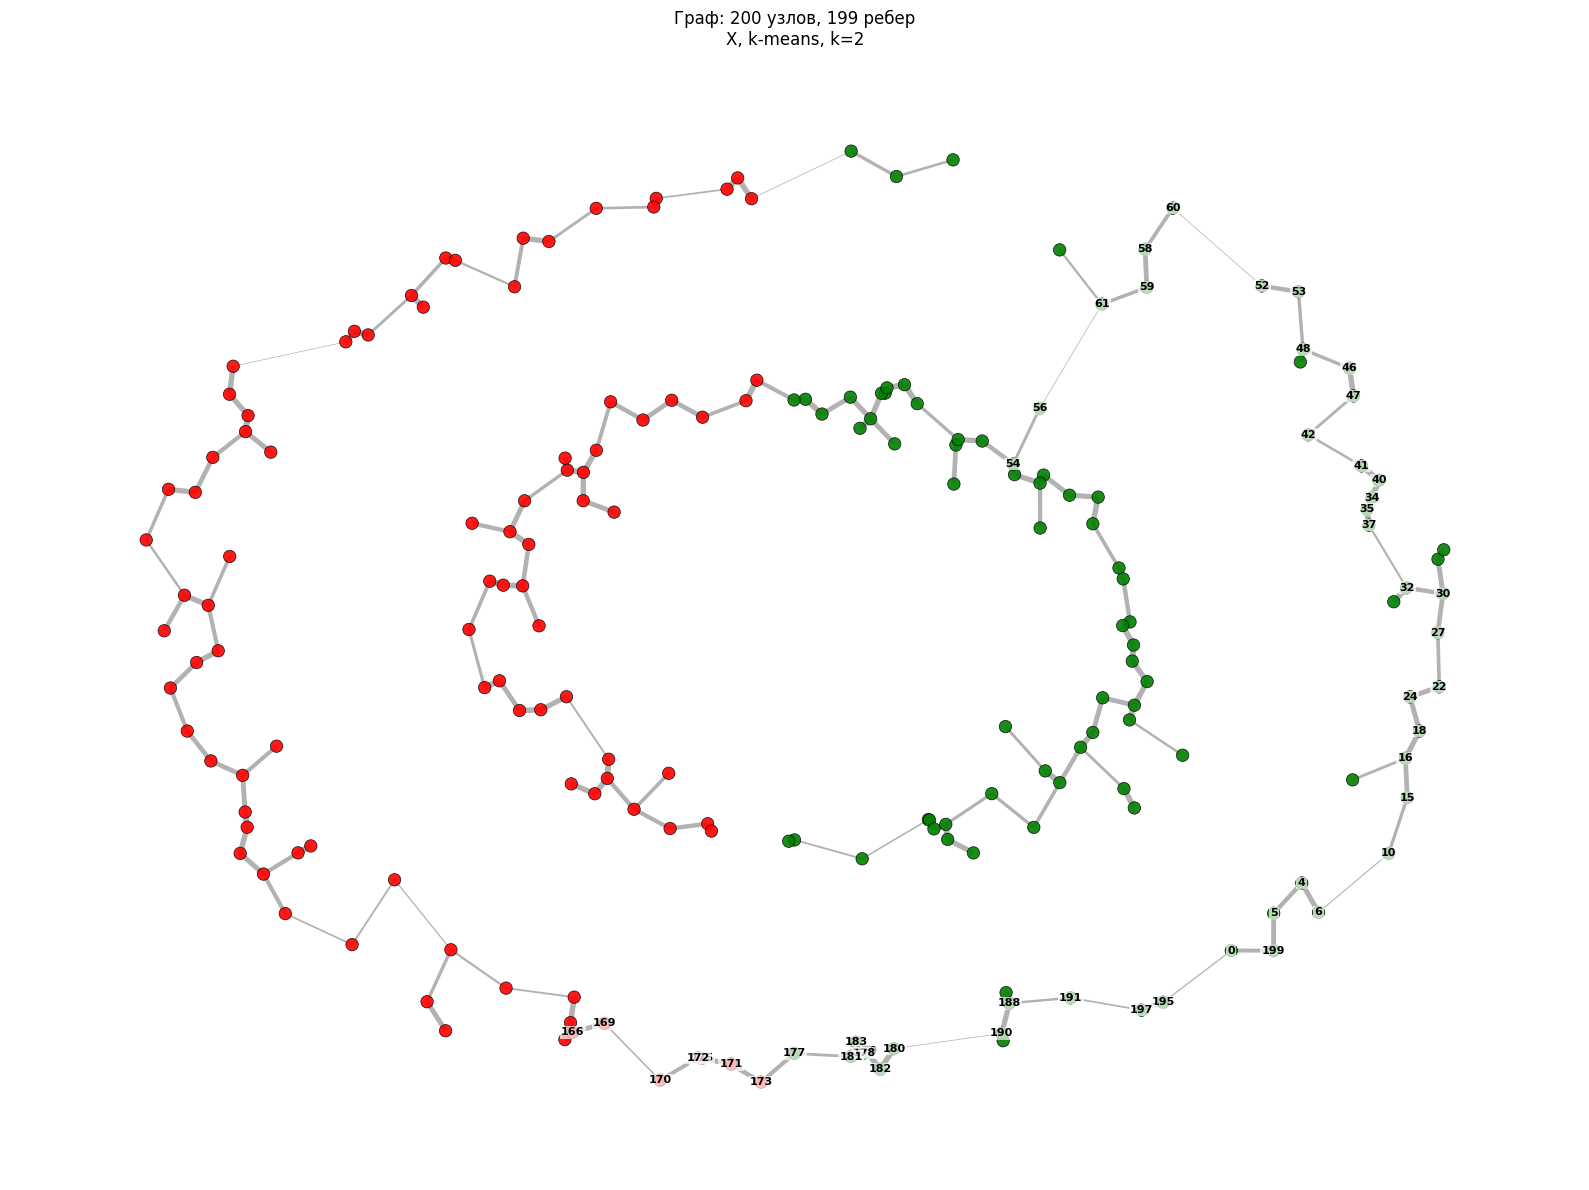

In [ ]:
#@title Кластеризация датасета X

def k_means(data, n_clusters = 2):
  model = KMeans(
      n_clusters=n_clusters,
      init='k-means++',
      n_init=10,
      max_iter=300,
      random_state=14343,
      algorithm='lloyd'
  )

  labels = model.fit_predict(data) + 1

  print(labels)
  return labels

kmeans_labels_x = k_means(X)
draw_weighted_graph(X_MST_graph, clusters=kmeans_labels_x, layout='custom', positions=X_pca, title="X, k-means, k=2")

[1 1 1 1 1 2 1 2 1 1 1 2 2 2 2 1 1 1 1 1 2 2 2 2 1 1 2 1 1 1 1 2 1 1 1 1 1
 1 2 1 2 1 1 2 1 1 1 1 1 2 1 2 2 1 1 2 1 1 2 2 1 1 2 2 2 2 1 2 2 2 2 1 1 1
 2 1 2 1 2 2 1 1 2 1 1 2 1 1 1 1 1 2 1 1 1 1 2 2 2 1 1 1 1 1 1 1 1 2 1 1 1
 1 2 1 2 1 2 1 2 1 2 1 2 1 2 2 1 1 2 1 1 2 1 1 1 2 2 1 1 1 2 1 2 1 1 2 2 1
 2 2 2 2 1 2 2 2 1 2 1 1 1 1 2 2 1 1 1 2 2 2 1 2 2 1 1 1 1 1 1 1 1 2 2 1 2
 2 1 2 2 1 1 1 1 2 2 2 2 2 1 1]


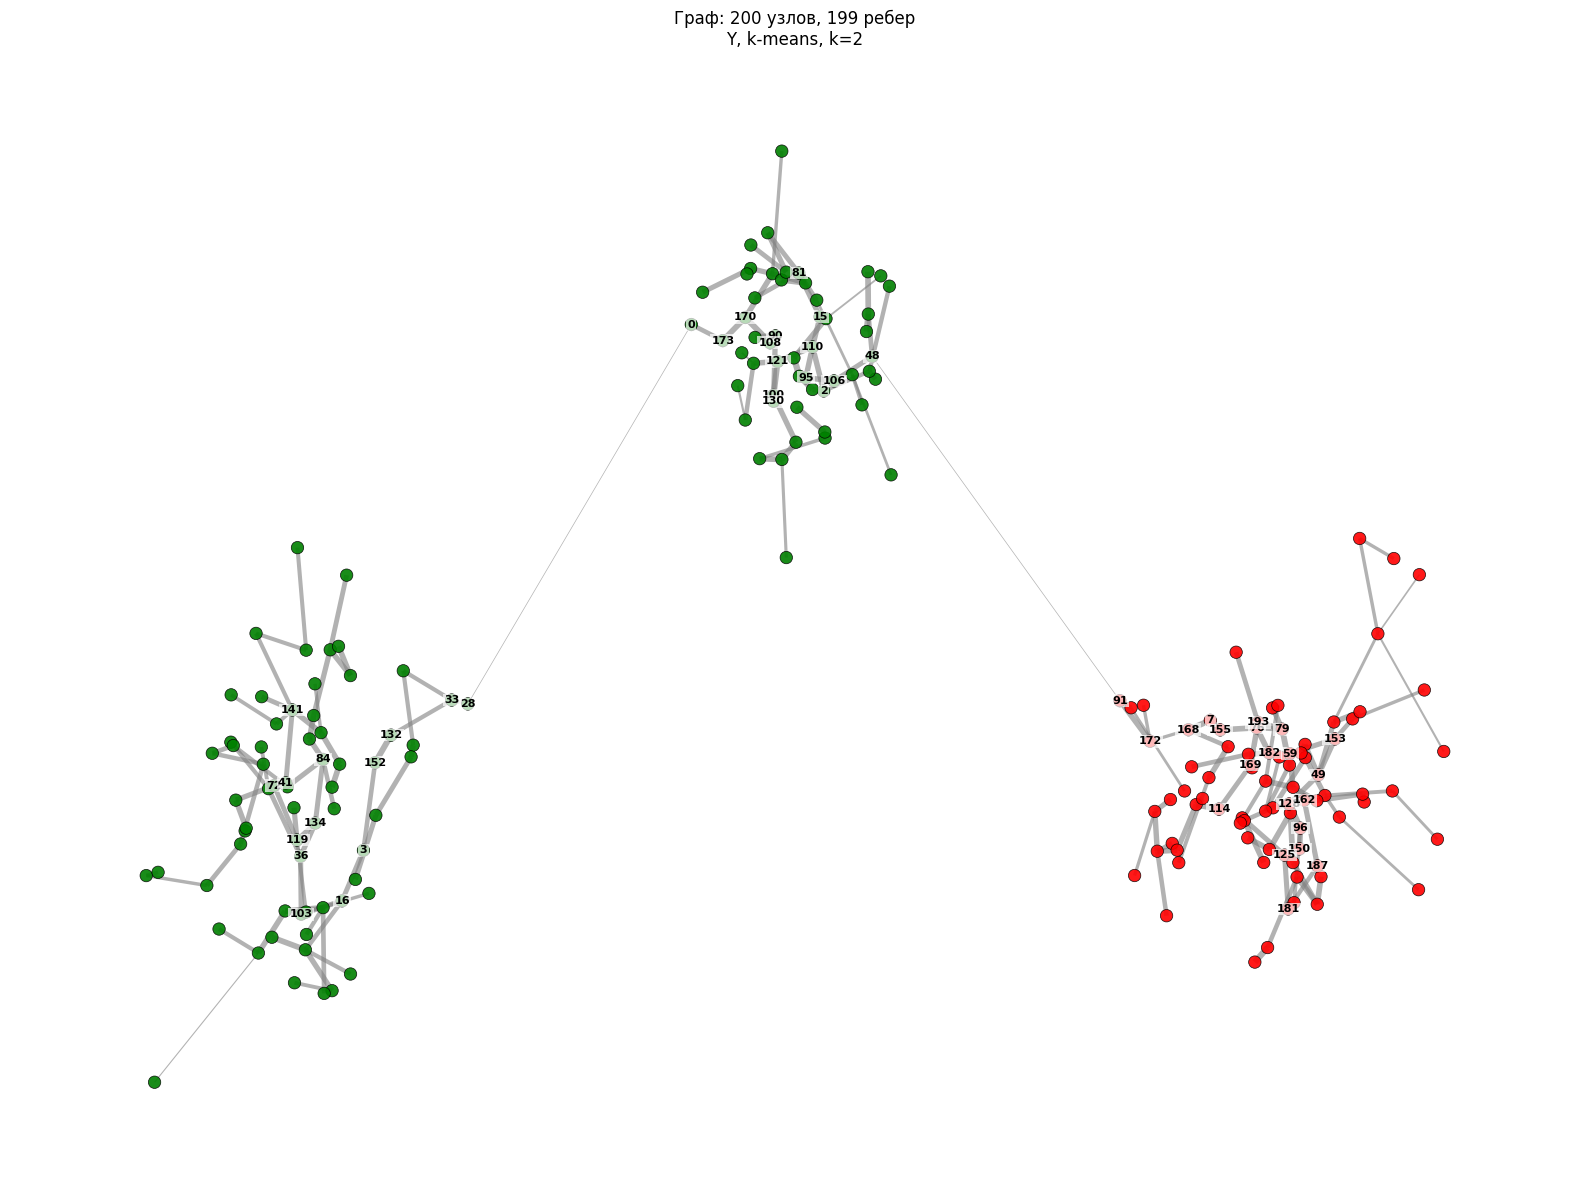

In [ ]:
#@title Кластеризация датасета Y

kmeans_labels_y = k_means(Y)
draw_weighted_graph(Y_MST_graph, clusters=kmeans_labels_y, layout='custom', positions=Y_pca, title="Y, k-means, k=2")

> **Вывод:** KMeans, в силу своих особенностей построения кластеров, идеально подходит для кластеризации Y, НО не для кластеризации X. Как было сказано ранее, эллипсы - не кучная структура, внутри одного эллипса есть диаметрально противоположные точки, расстояние между которыми велико, но тем не менее, они должны принадлежать одному кластеру. KMeans не удобна такая кластерная структура: в целях минимизации внутрикластерного расстояния, KMeans делит выборку на 2 части некоторой вертикальной линией, предполагая, что оба кластера - кучные структуры, плотно сконцентрированные точки, что на самом деле не так.  

### EM кластеризация

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 2 1 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


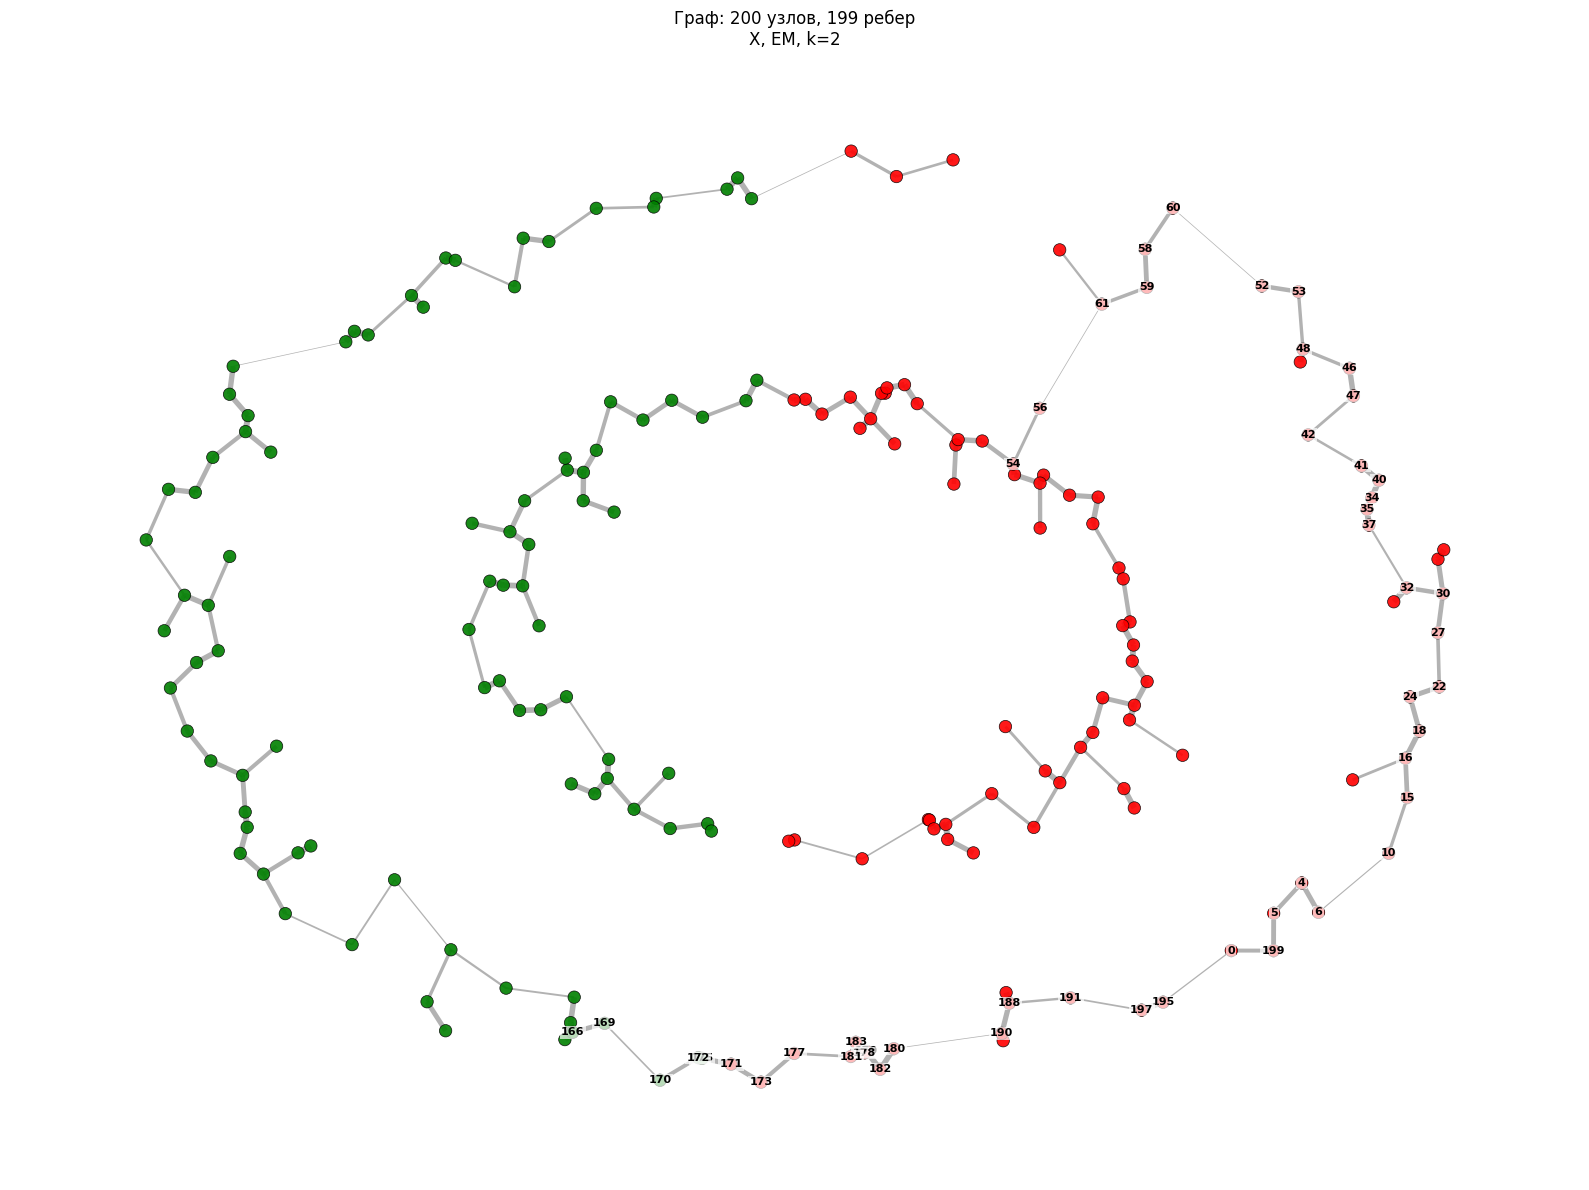

In [ ]:
#@title Кластеризация датасета X

def EM(data, n_clusters=2):
  model = GaussianMixture(
      n_components=n_clusters,
      covariance_type='full',
      max_iter=200,
      n_init=20,
      init_params='kmeans',
      random_state=12143,
      verbose=0
  )

  model.fit(data)
  labels = model.predict(data) + 1

  print(labels)
  return labels

EM_labels_x = EM(X)
draw_weighted_graph(X_MST_graph, clusters=EM_labels_x, layout='custom', positions=X_pca, title="X, EM, k=2")

[1 1 1 1 1 2 1 2 1 1 1 2 2 2 2 1 1 1 1 1 2 2 2 2 1 1 2 1 1 1 1 2 1 1 1 1 1
 1 2 1 2 1 1 2 1 1 1 1 1 2 1 2 2 1 1 2 1 1 2 2 1 1 2 2 2 2 1 2 2 2 2 1 1 1
 2 1 2 1 2 2 1 1 2 1 1 2 1 1 1 1 1 2 1 1 1 1 2 2 2 1 1 1 1 1 1 1 1 2 1 1 1
 1 2 1 2 1 2 1 2 1 2 1 2 1 2 2 1 1 2 1 1 2 1 1 1 2 2 1 1 1 2 1 2 1 1 2 2 1
 2 2 2 2 1 2 2 2 1 2 1 1 1 1 2 2 1 1 1 2 2 2 1 2 2 1 1 1 1 1 1 1 1 2 2 1 2
 2 1 2 2 1 1 1 1 2 2 2 2 2 1 1]


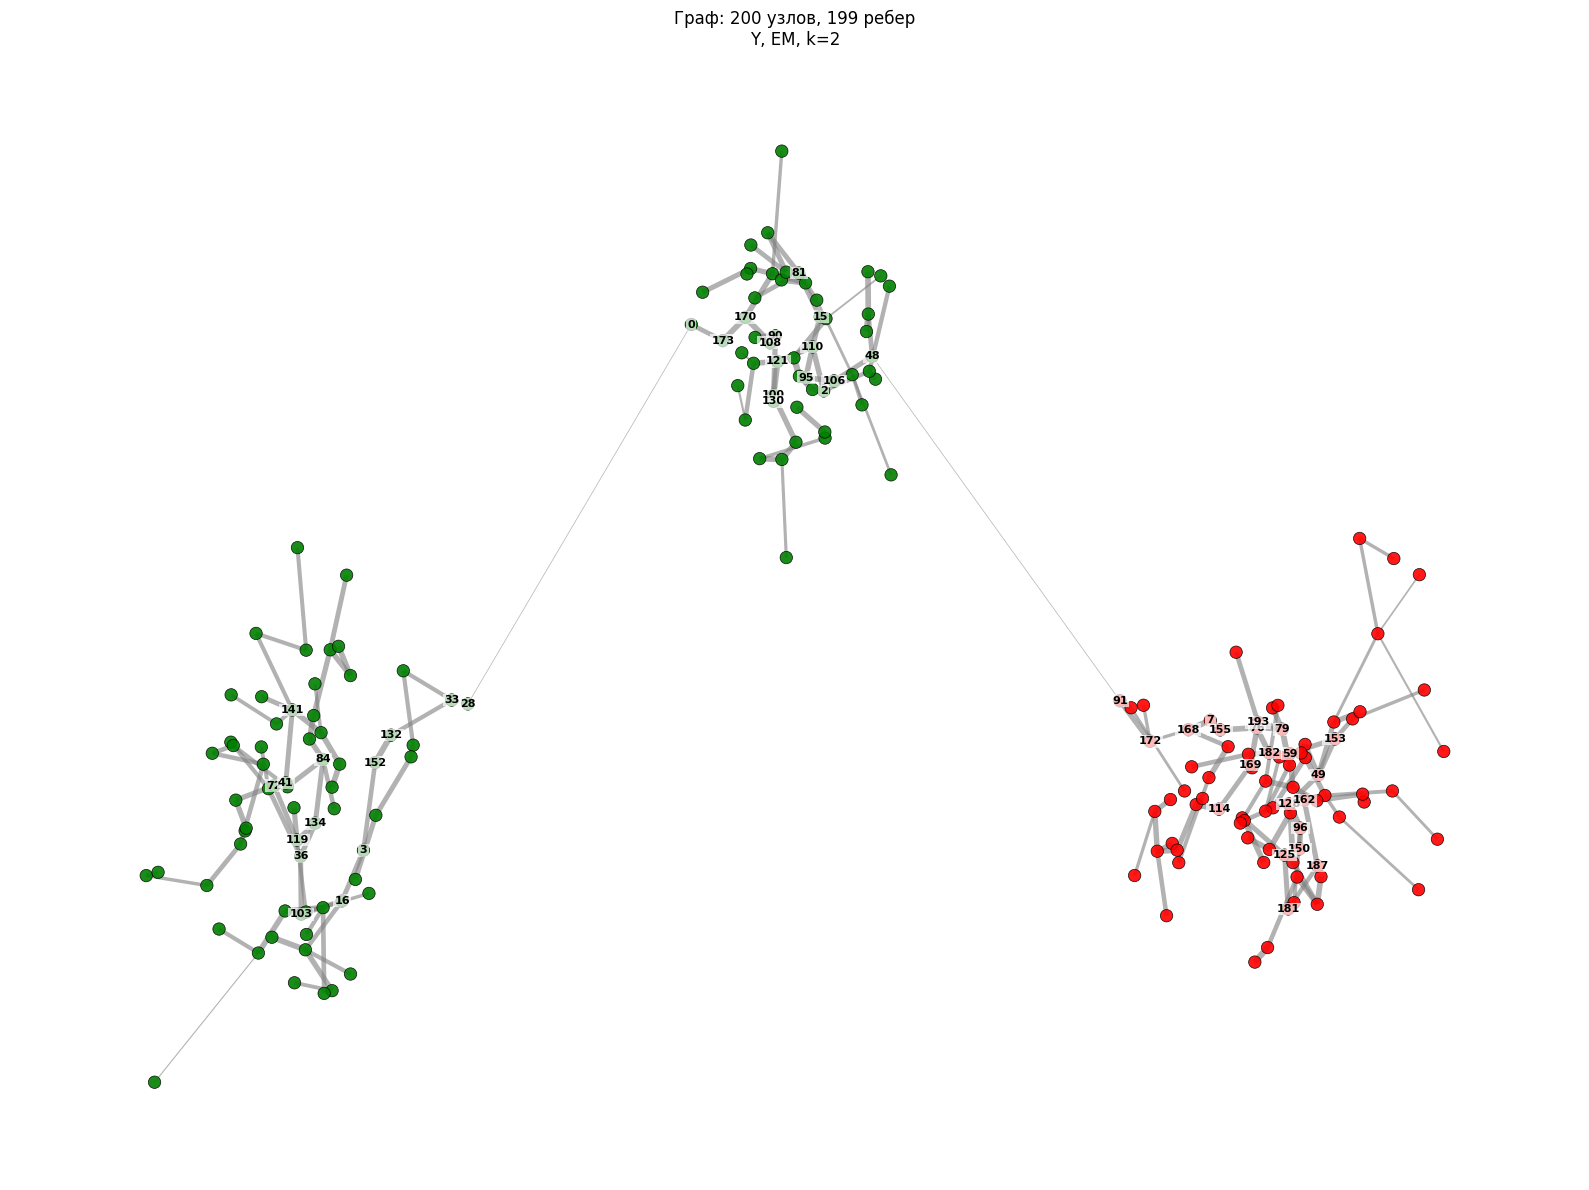

In [ ]:
#@title Кластеризация датасета Y

EM_labels_y = EM(Y)
draw_weighted_graph(Y_MST_graph, clusters=EM_labels_y, layout='custom', positions=Y_pca, title="Y, EM, k=2")

> **Вывод:** в обоих случаях EM алгоритм ищет распределение обоих кластеров как двумерное эллиптическое распределение, что, опять же, идеально подходит для датасета Y, но не для X

### Спектральная кластеризация на основе графовой модели (матрица смежности, нормализованный лапласиан)

[2 1 1 1 2 2 2 1 1 1 2 1 1 2 1 2 2 1 2 1 1 1 2 1 2 1 1 2 1 2 2 2 2 2 2 2 1
 2 1 1 2 2 2 1 1 1 2 2 2 2 1 1 2 2 1 1 1 1 2 2 2 2 1 2 1 1 1 1 1 1 1 1 1 1
 2 2 2 1 1 1 2 2 2 1 1 2 2 1 1 1 1 2 2 2 2 2 1 1 1 2 2 1 2 1 2 2 2 1 1 2 2
 1 2 2 2 2 1 1 1 1 2 2 2 2 1 2 2 2 2 1 2 2 1 1 2 1 1 2 2 2 2 1 2 2 2 1 2 2
 1 2 1 2 1 2 1 1 1 2 2 2 1 2 2 2 2 1 2 1 1 2 2 2 2 2 1 2 1 2 2 2 2 2 2 2 1
 2 2 1 2 1 2 2 1 1 1 2 1 2 1 2]


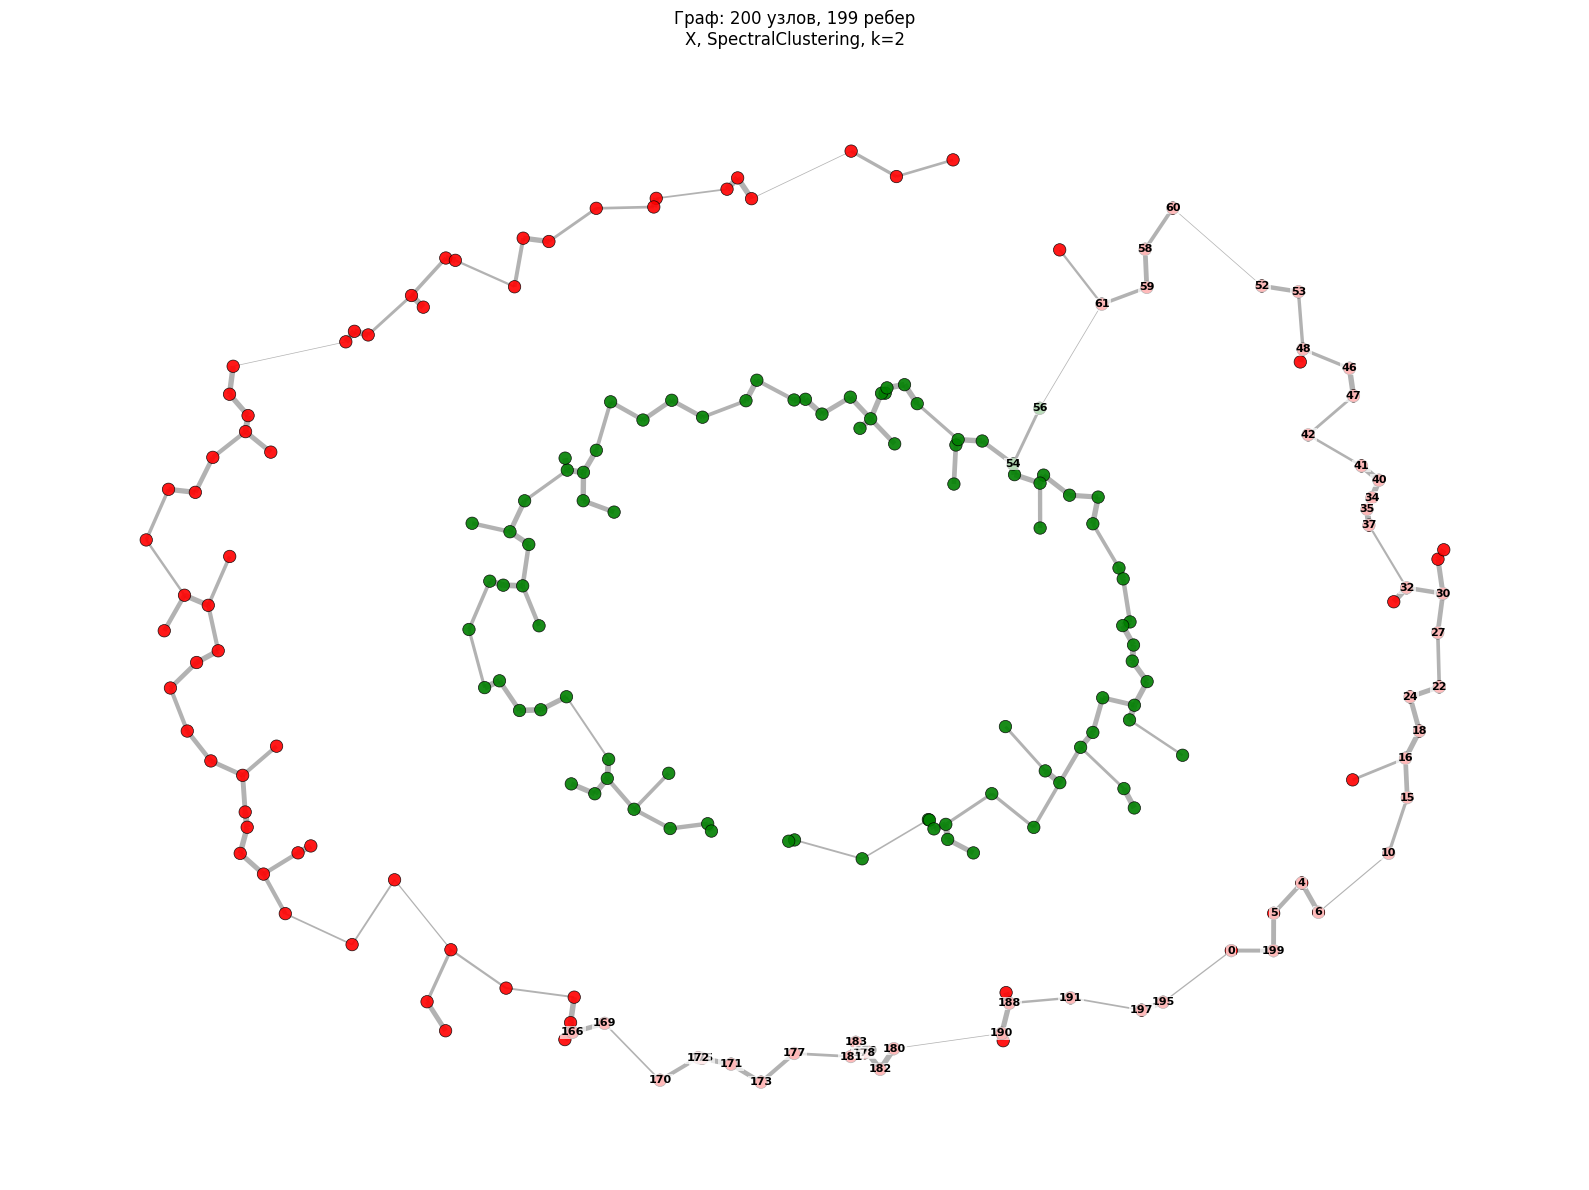

In [ ]:
#@title Кластеризация датасета X

def SpectralClustering(G, n_clusters=2, laplacian_type='sym'):
    W = nx.adjacency_matrix(G).toarray()
    D = np.diag(np.sum(W, axis=1))
    D_inv_sqrt = np.diag(1.0 / np.sqrt(np.diag(D)))
    D_inv = np.diag(1.0 / np.diag(D))

    if laplacian_type == 'classic':
        L = D - W
    elif laplacian_type == 'sym':
        # L_sym = I - D^(-1/2) * W * D^(-1/2)
        L = np.eye(X.shape[0]) - D_inv_sqrt @ W @ D_inv_sqrt
    elif laplacian_type == 'rw':
        L = np.eye(X.shape[0]) - D_inv @ W

    # Сингулярное разложение
    eigenvalues, eigenvectors = np.linalg.eigh(L)
    idx = np.argsort(eigenvalues)[:n_clusters]

    # Laplacian embedding
    embedding = eigenvectors[:, idx]
    embedding /= np.linalg.norm(embedding, axis=0, keepdims=True)

    kmeans = KMeans(n_clusters=n_clusters, random_state=12141, n_init=10)
    labels = kmeans.fit_predict(embedding) + 1

    print(labels)
    return labels


SC_labels_x = SpectralClustering(X_graph_model)
draw_weighted_graph(X_MST_graph, clusters=SC_labels_x, layout='custom', positions=X_pca, title="X, SpectralClustering, k=2")

[2 2 2 2 2 1 2 1 2 2 2 1 1 1 1 2 2 2 2 2 1 1 1 1 2 2 1 2 2 2 2 1 2 2 2 2 2
 2 1 2 1 2 2 1 2 2 2 2 2 1 2 1 1 2 2 1 2 2 1 1 2 2 1 1 1 1 2 1 1 1 1 2 2 2
 1 2 1 2 1 1 2 2 1 2 2 1 2 2 2 2 2 1 2 2 2 2 1 1 1 2 2 2 2 2 2 2 2 1 2 2 2
 2 1 2 1 2 1 2 1 2 1 2 1 2 1 1 2 2 1 2 2 1 2 2 2 1 1 2 2 2 1 2 1 2 2 1 1 2
 1 1 1 1 2 1 1 1 2 1 2 2 2 2 1 1 2 2 2 1 1 1 2 1 1 2 2 2 2 2 2 2 2 1 1 2 1
 1 2 1 1 2 2 2 2 1 1 1 1 1 2 2]


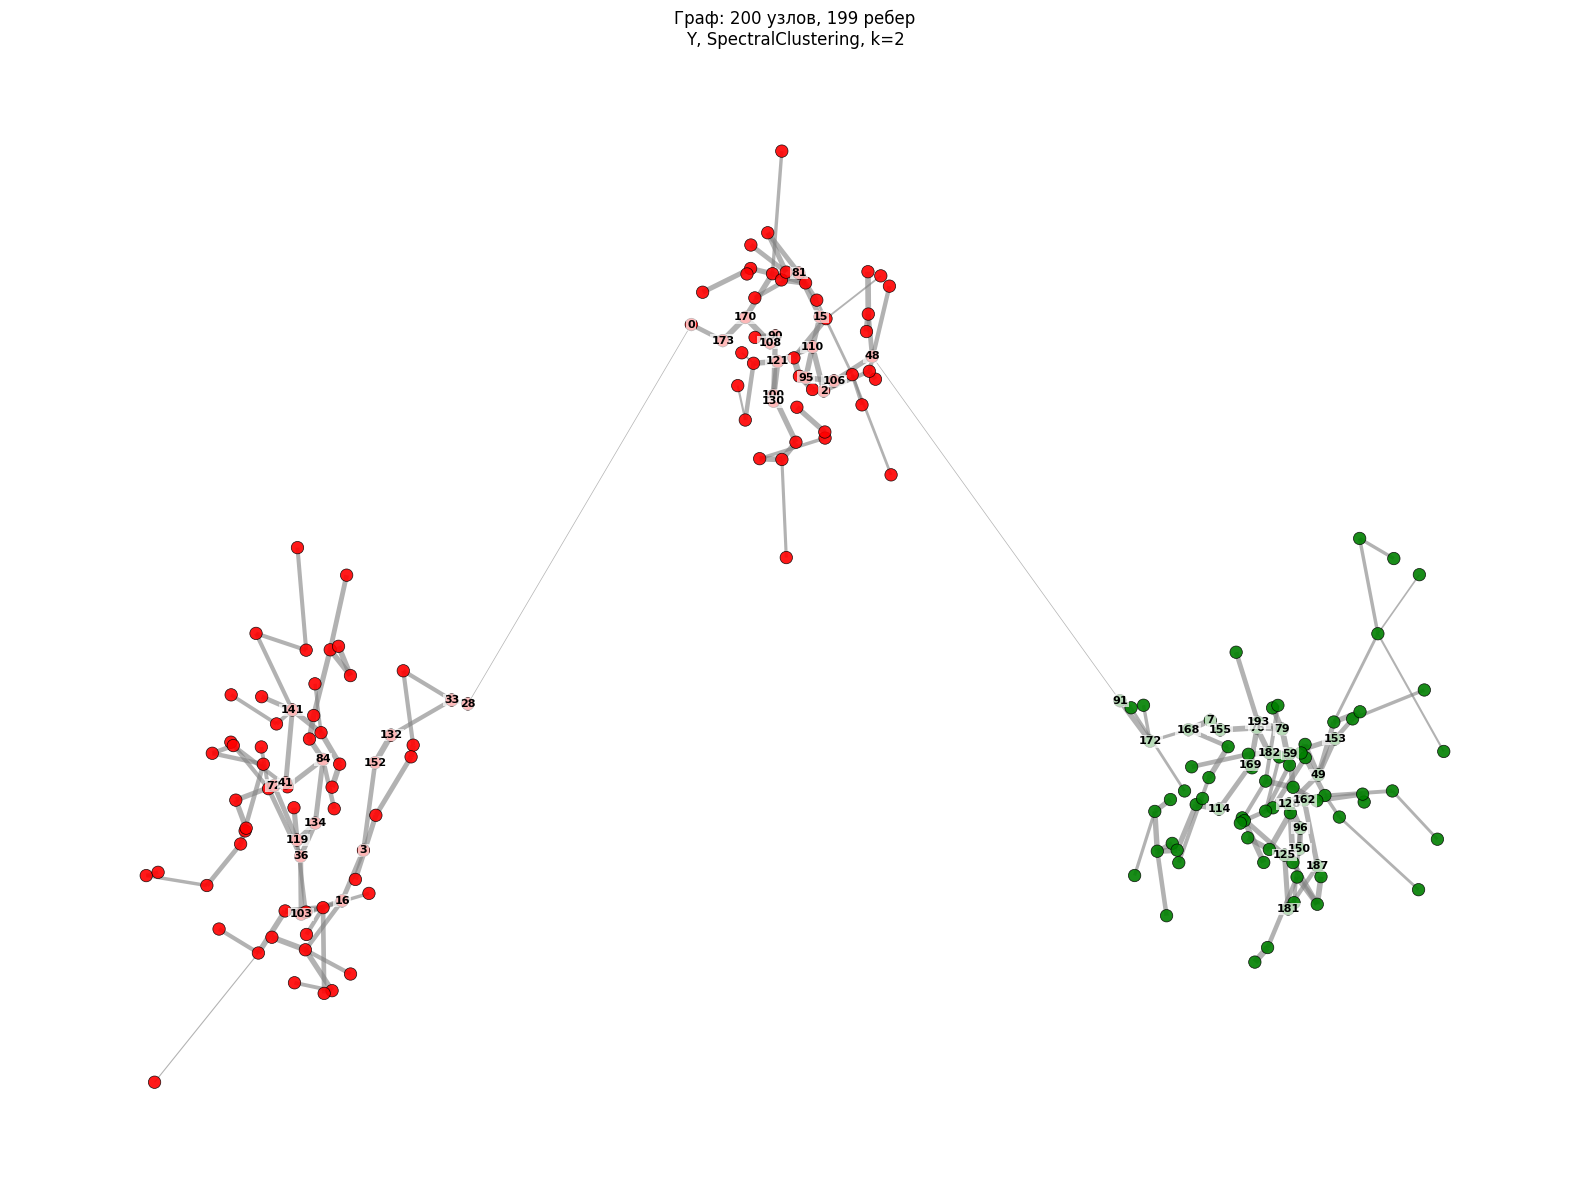

In [ ]:
#@title Кластеризация датасета Y

SC_labels_y = SpectralClustering(Y_graph_model)
draw_weighted_graph(Y_MST_graph, clusters=SC_labels_y, layout='custom', positions=Y_pca, title="Y, SpectralClustering, k=2")

> **Вывод:** спектральная кластеризация идеально справилась с кластеризацией X. Причина: правильно подобранный параметр $\sigma$. Обеспечив малое значение $\sigma$, функция схожести стала почти схожей с пороговой функцией, за счет чего алгоритм максимально ориентируется на ближайших соседей. Результаты понижения размерности через спектральное разложение лапласиана получаются очень хорошими - получающиеся в двумерном пространстве точки оказываются линейно разделимыми, и их очень легко кластеризовать, например, через KMeans.

### 1.2 Сравнить попарно разбиения, полученные разными методами с помощью RAND индекса

In [ ]:
all_labels_k2_x = {
  "SingleLinkage": SL_labels_x,
  "CentroidLinkage" : CL_labels_x,
  "k-means": kmeans_labels_x,
  "EM": EM_labels_x,
  "SpectralClustering": SC_labels_x
}

all_labels_k2_y = {
  "SingleLinkage": SL_labels_y,
  "CentroidLinkage" : CL_labels_x,
  "k-means": kmeans_labels_y,
  "EM": EM_labels_y,
  "SpectralClustering": SC_labels_y
}

METHODS_NAMES = ["SingleLinkage", "CentroidLinkage", "k-means", "EM", "SpectralClustering"]

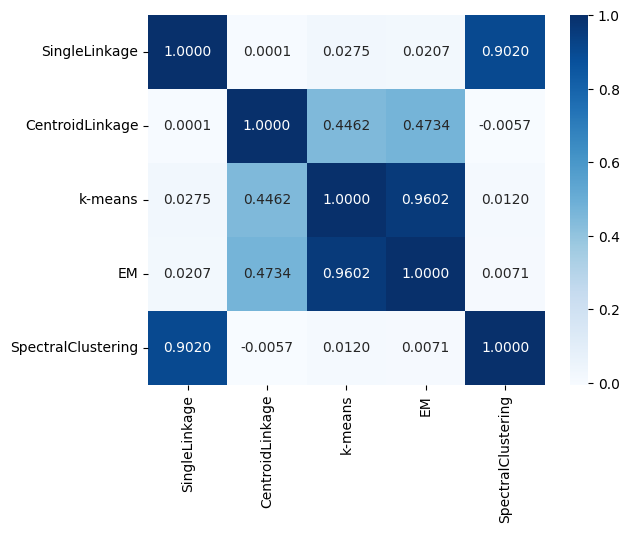

In [ ]:
#@title Сравнение методов кластеризаций через rand индекс (датасет X)

def compare_rand_matrix(dict_labels):
  n_methods = len(dict_labels.keys())
  rand_matrix = np.zeros((n_methods, n_methods))

  for i in range(n_methods):
    for j in range(n_methods):
      labels_i = dict_labels[METHODS_NAMES[i]]
      labels_j = dict_labels[METHODS_NAMES[j]]

      # Используем Adjusted Rand Index для лучшей интерпретируемости
      rand_matrix[i, j] = adjusted_rand_score(labels_i, labels_j)

  rand_df = pd.DataFrame(rand_matrix,
                      index=METHODS_NAMES,
                      columns=METHODS_NAMES)

  return rand_df

rand_df = compare_rand_matrix(all_labels_k2_x)
sns.heatmap(rand_df, cmap='Blues', annot=True, fmt='.4f')
plt.show()

* Результаты $> 0.9$ не вызывают вопросов в силу почти полной схожести результатов кластеризации, полученных на картинках выше.

* Результаты Spectral Clustering и Single Linkage значительно отличаются от других полученных результатов, чем и объясняется малое значение RAND индексов. Фактически, алгоритмы делятся на 2 типа по результатам кластеризации X: найденные кластеры - эллипсы и найденные кластеры - набор плотно сконцентрированных точек.

* Результаты Centroid Linkage несколько отличаются от результатов EM и KMeans. У EM и KMeans получились почти равные по числу вершин кластеры, а у Centroid Linkage - скорее в соотношении 1 к 2, чем и объясняется небольшое значение rand индекса в сравнении с KMeans и EM.

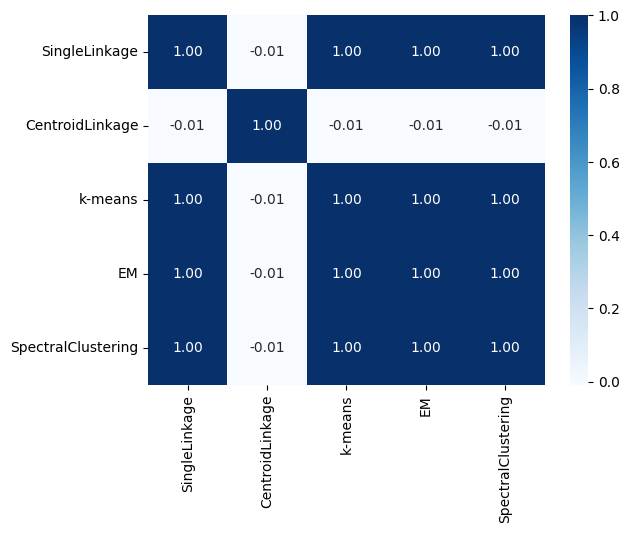

In [ ]:
#@title Сравнение методов кластеризаций через rand индекс (датасет Y)

rand_df = compare_rand_matrix(all_labels_k2_y)
sns.heatmap(rand_df, cmap='Blues', annot=True, fmt='.2f')
plt.show()

* Действительно, результаты почти всех алгоритмов схожи

* Centoid Linkage объединил 2 других кластера в один, в отличие от всех других алгоритмов. Это значительно повлияло на значение rand индекса.

### 1.3 Вычислить значение функции модулярности для каждого разбиения на 2 кластера

Функция модулярности $Q$:

$$Q = \frac{1}{2m} \sum_{i, j} (w_{i, j} - \frac{k_i k_j}{2m}) \delta(i, j)$$

$k_i = \sum_{j} w_{i, j}$ - степень вершины $i$

$m$ - общее число ребер в графе

$$\begin{aligned}
    \delta(i, j) =
    \begin{cases}
              1, \text{если вершины i, j в одном кластере} \\
              0, \text{если вершины i, j в разных кластерах}
    \end{cases}
\end{aligned}$$


In [ ]:
def calculate_modularity(graph, all_labels):
  m = graph.number_of_edges()
  degrees = np.array([d for _, d in graph.degree()])
  dist_matrix = nx.adjacency_matrix(graph).toarray()

  all_Q = dict()

  for name, labels in all_labels.items():
    Q = 0.0

    for i in range(len(graph.nodes())):
      for j in range(len(graph.nodes())):
        if labels[i] == labels[j]:
          expected = (degrees[i] * degrees[j]) / (2 * m)
          actual = dist_matrix[i, j]
          Q += (actual - expected)

      Q = Q / (2 * m)

    all_Q[name] = Q

  return all_Q

In [ ]:
#@title Запуск иерархических кластеризаций

HIERARCHY_CLUSTERING_NAMES = ['single', 'complete', 'average', 'centroid', 'ward']

def all_hierarchy_clustering(dist_matrix, n_clusters=2):
  all_labels = dict()
  condensed_dist_matrix = squareform(dist_matrix)
  for name in HIERARCHY_CLUSTERING_NAMES:
    Z = linkage(condensed_dist_matrix, method=name)
    all_labels[name] = fcluster(Z, t=n_clusters, criterion='maxclust')

  return all_labels

In [ ]:
#@title Модулярности для датасета X

all_labels = all_hierarchy_clustering(X_dist_matrix)

all_Q = calculate_modularity(X_graph_model, all_labels)
df = pd.DataFrame(all_Q.items(), columns=['Method', 'Modularity'])

df

Method  Modularity
0    single   -0.002136
1  complete   -0.001815
2   average   -0.002008
3  centroid   -0.002678
4      ward   -0.002248

In [ ]:
#@title Модулярности для датасета Y

all_labels = all_hierarchy_clustering(Y_dist_matrix)

all_Q = calculate_modularity(Y_graph_model, all_labels)
df = pd.DataFrame(all_Q.items(), columns=['Method', 'Modularity'])

df

Method  Modularity
0    single   -0.001444
1  complete   -0.001601
2   average   -0.001601
3  centroid   -0.001601
4      ward   -0.001444

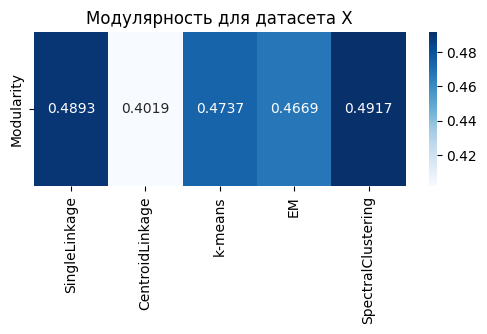

In [ ]:
#@title Сравнение методов кластеризации через модулярность (датасет X)

def compare_modularity(dict_labels, G):
    n_methods = len(dict_labels.keys())
    modularity_matrix = np.zeros((1, n_methods))

    for i in range(n_methods):
        labels_i = dict_labels[METHODS_NAMES[i]]

        communities = [set() for _ in range(max(labels_i))]
        for j in range(len(labels_i)):
            communities[labels_i[j] - 1].add(j)

        modularity_matrix[0, i] = nx.community.modularity(G, communities)

    df = pd.DataFrame(modularity_matrix,
                    index=['Modularity'],
                    columns=METHODS_NAMES)

    return df


modularity_df = compare_modularity(all_labels_k2_x, X_graph_model)
plt.figure(figsize=(6, 2))
ax = sns.heatmap(modularity_df, cmap='Blues', annot=True, fmt='.4f')
ax.set_title('Модулярность для датасета X')
plt.show()

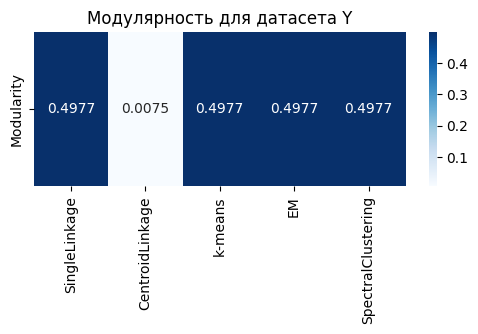

In [ ]:
#@title Сравнение методов кластеризации через модулярность (датасет Y)

modularity_df = compare_modularity(all_labels_k2_y, Y_graph_model)
plt.figure(figsize=(6, 2))
ax = sns.heatmap(modularity_df, cmap='Blues', annot=True, fmt='.4f')
ax.set_title('Модулярность для датасета Y')
plt.show()

* Для датасета X значения модулярности отличаются в силу различия полученных результатов. Значения, соответствующие Single Linkage и Spectral Clustering получились выше, и именно они выделили два кластера как 2 эллипса. Остальные алгоритмы искали кучную кластерную структуру с некоторым центром, результаты модулярности для них оказались несколько меньше

* Значения модулярности для датасета Y оказались одинаковыми в силу одинаковых результатов с точностью до перестановки номеров кластеров. CentroidLinkage кластеризовал 2 других набора данных, в отличие от остальных алгоритмов, поэтому результаты модулярности для него значительно отличаются.

## Кластеризация для числа кластеров $k=3$

### Single и Centroid Linkage кластеризация

[3 2 2 2 3 3 3 2 2 2 3 2 2 3 2 3 3 2 3 2 2 2 3 2 3 2 2 3 2 3 3 3 3 3 3 3 2
 3 2 2 3 3 3 2 2 2 3 3 3 3 2 2 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 1 1 1 2 2 2 1 1 1 2 2 1 1 2 2 2 2 1 1 1 1 1 2 2 2 1 1 2 1 2 1 1 1 2 2 3 3
 2 3 3 3 3 2 2 2 2 3 3 3 3 2 3 3 3 3 2 3 3 2 2 3 2 2 3 3 3 3 2 3 3 3 2 3 3
 2 3 2 3 2 3 2 2 2 3 3 3 2 3 3 3 3 2 3 2 2 3 3 3 3 3 2 3 2 3 3 3 3 3 3 3 2
 3 3 2 3 2 3 3 2 2 2 3 2 3 2 3]


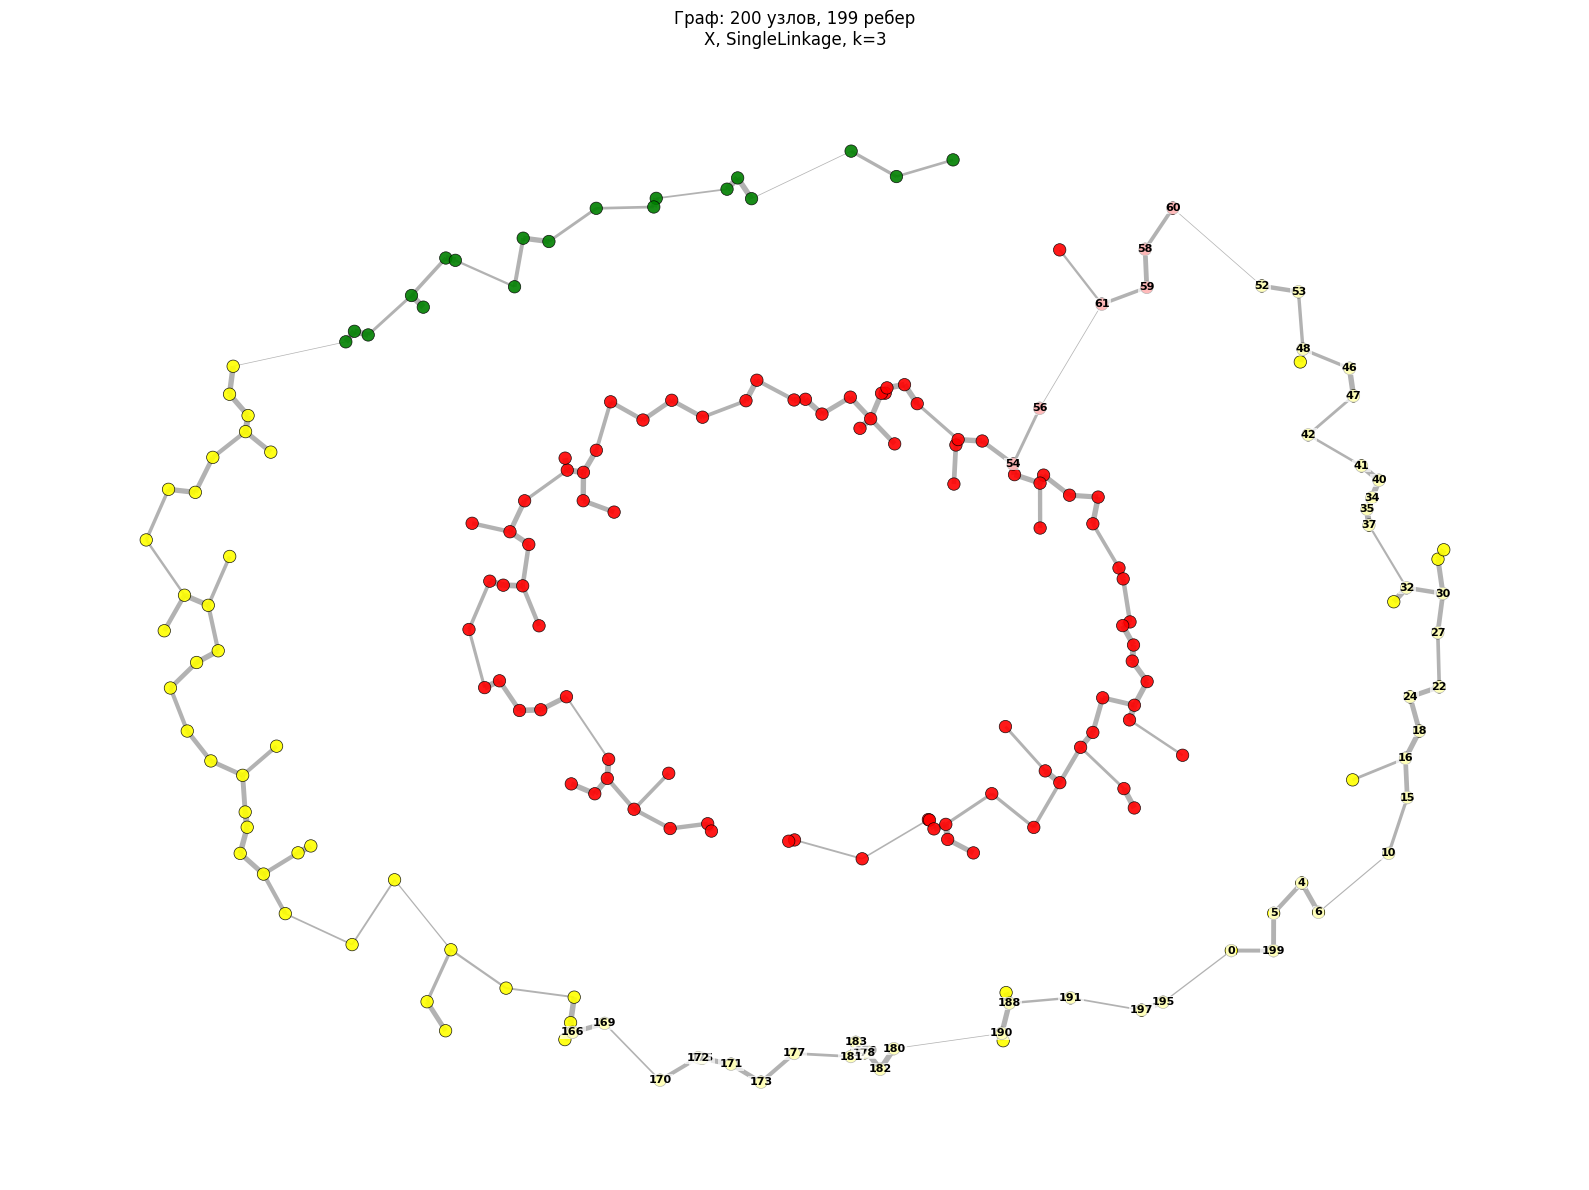

In [ ]:
#@title Кластеризация датасета X (Single Linkage)

condensed_dist_matrix = squareform(X_dist_matrix)
Z = linkage(condensed_dist_matrix, method='single')
SL_labels_k3_x = fcluster(Z, t=3, criterion='maxclust')
print(SL_labels_k3_x)

draw_weighted_graph(X_MST_graph, clusters=SL_labels_k3_x, layout='custom', positions=X_pca, title="X, SingleLinkage, k=3")

> **Вывод:** расстояние между некоторыми объектами во внешнем эллипсе достаточно большое, из-за чего внешний эллипс дробится на несколько кластеров

[2 3 2 3 2 1 2 1 2 2 3 1 1 1 1 2 3 3 3 3 1 1 1 1 2 2 1 2 3 3 2 1 2 3 3 2 3
 2 1 3 1 3 3 1 2 2 2 2 2 1 3 1 1 3 3 1 3 3 1 1 2 2 1 1 1 1 3 1 1 1 1 2 3 3
 1 3 1 3 1 1 2 2 1 3 3 1 2 3 3 3 2 1 3 3 2 2 1 1 1 2 2 3 3 3 2 2 2 1 2 3 2
 2 1 3 1 2 1 2 1 3 1 2 1 2 1 1 3 3 1 3 2 1 3 3 3 1 1 3 2 3 1 3 1 3 3 1 1 3
 1 1 1 1 3 1 1 1 3 1 3 3 3 2 1 1 2 2 3 1 1 1 2 1 1 2 3 3 2 3 2 3 2 1 1 3 1
 1 3 1 1 3 2 3 2 1 1 1 1 1 3 2]


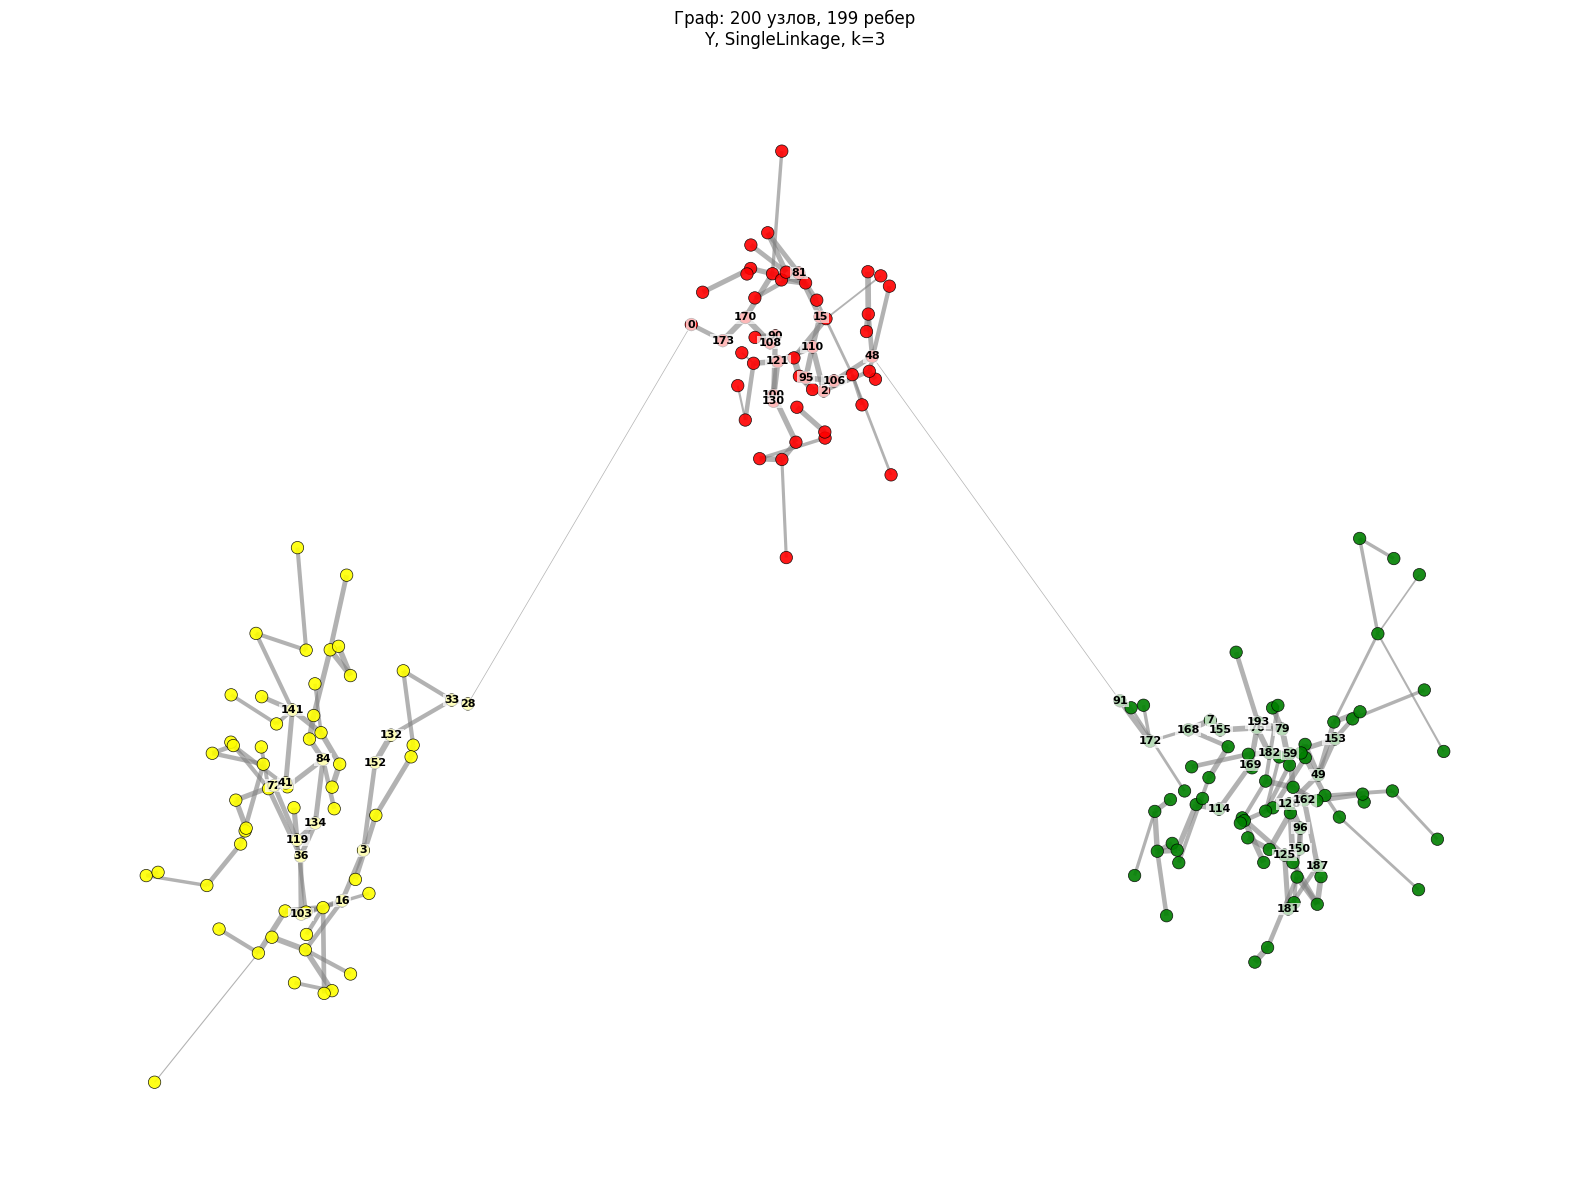

In [ ]:
#@title Кластеризация датасета Y (Single Linkage)

condensed_dist_matrix = squareform(Y_dist_matrix)
Z = linkage(condensed_dist_matrix, method='single')
SL_labels_k3_y = fcluster(Z, t=3, criterion='maxclust')
print(SL_labels_k3_y)

draw_weighted_graph(Y_MST_graph, clusters=SL_labels_k3_y, layout='custom', positions=Y_pca, title="Y, SingleLinkage, k=3")

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 1 1]


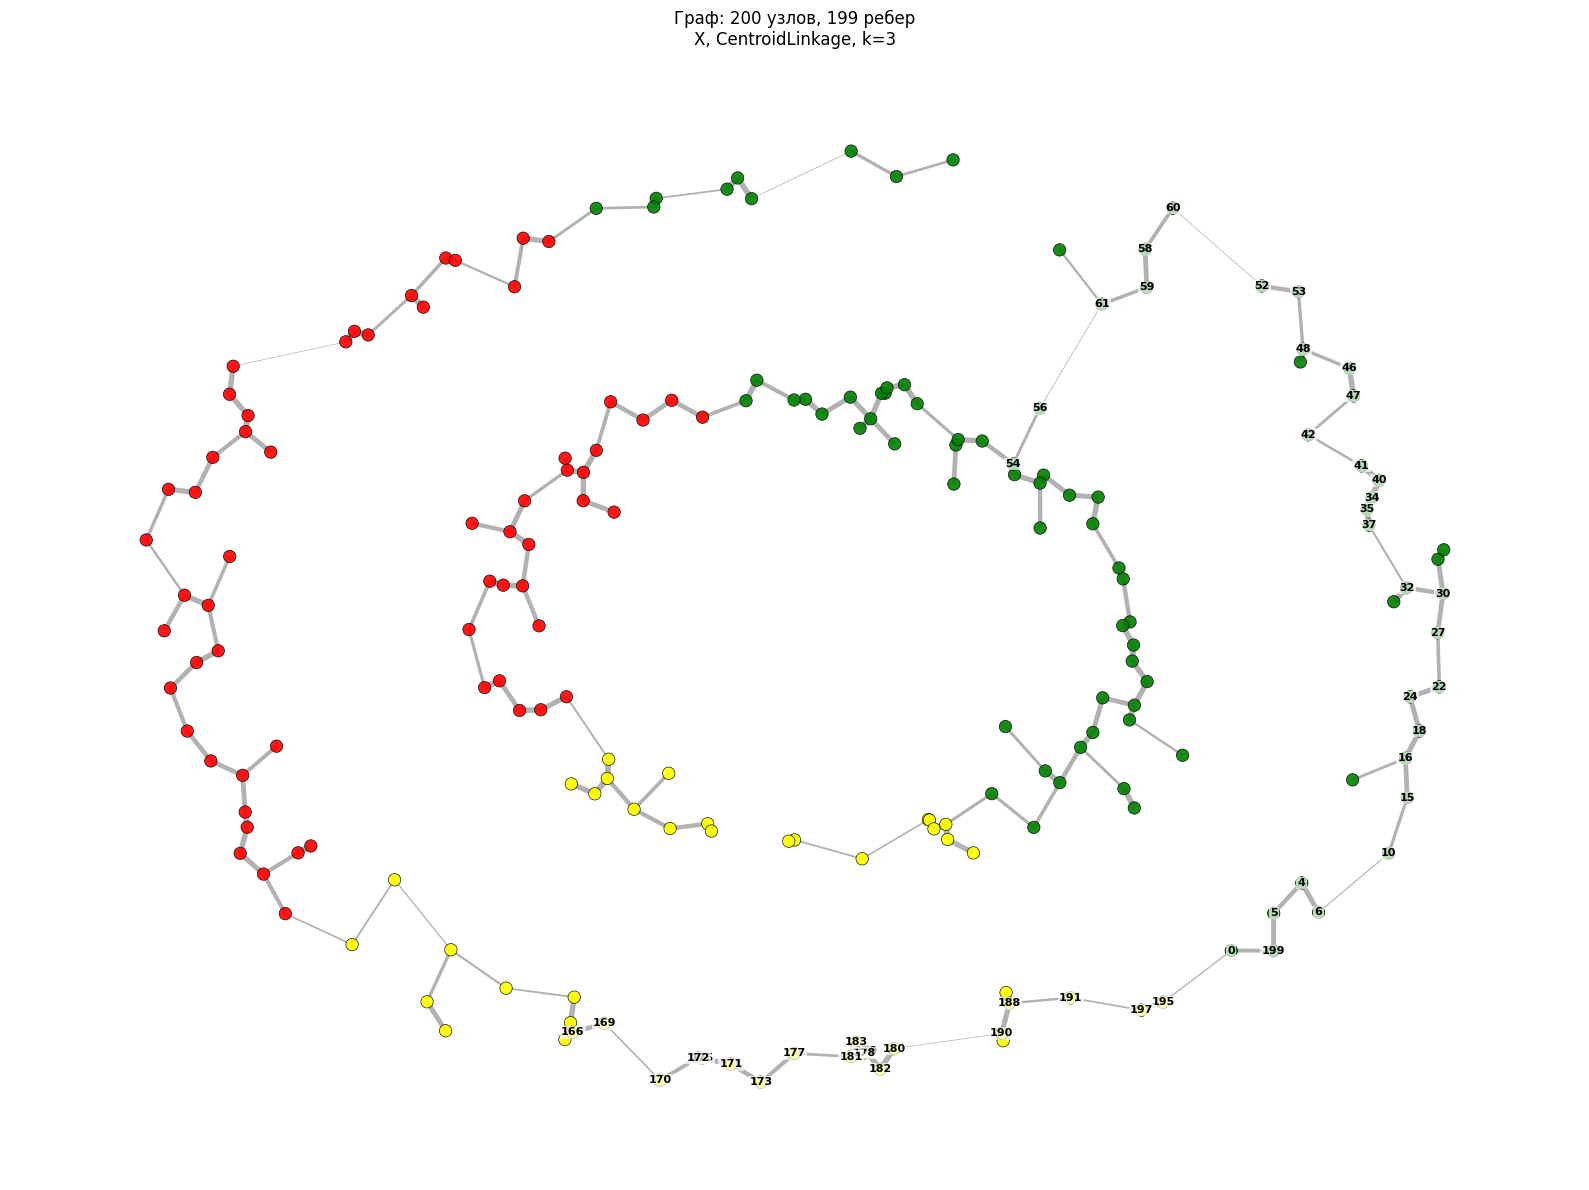

In [ ]:
#@title Кластеризация датасета X (CentroidLinkage)

CL_labels_k3_x = CentroidLinkage(X_dist_matrix, n_clusters=3)

draw_weighted_graph(X_MST_graph, clusters=CL_labels_k3_x, layout='custom', positions=X_pca, title="X, CentroidLinkage, k=3")

[2 1 2 1 2 3 2 3 2 2 1 3 3 3 3 2 1 1 1 1 3 3 3 3 2 2 3 2 1 1 2 3 2 1 1 2 1
 2 3 1 3 1 1 3 2 2 2 2 2 3 1 3 3 1 1 3 1 1 3 3 2 2 3 3 3 3 1 3 3 3 3 2 1 1
 3 1 3 1 3 3 2 2 3 1 1 3 2 1 1 1 2 3 1 1 2 2 3 3 3 2 2 1 1 1 2 2 2 3 2 1 2
 2 3 1 3 2 3 2 3 1 3 2 3 2 3 3 1 1 3 1 2 3 1 1 1 3 3 1 2 1 3 1 3 1 1 3 3 1
 3 3 3 3 1 3 3 3 1 3 1 1 1 2 3 3 2 2 1 3 3 3 2 3 3 2 1 1 2 1 2 1 2 3 3 1 3
 3 1 3 3 1 2 1 2 3 3 3 3 3 1 2]


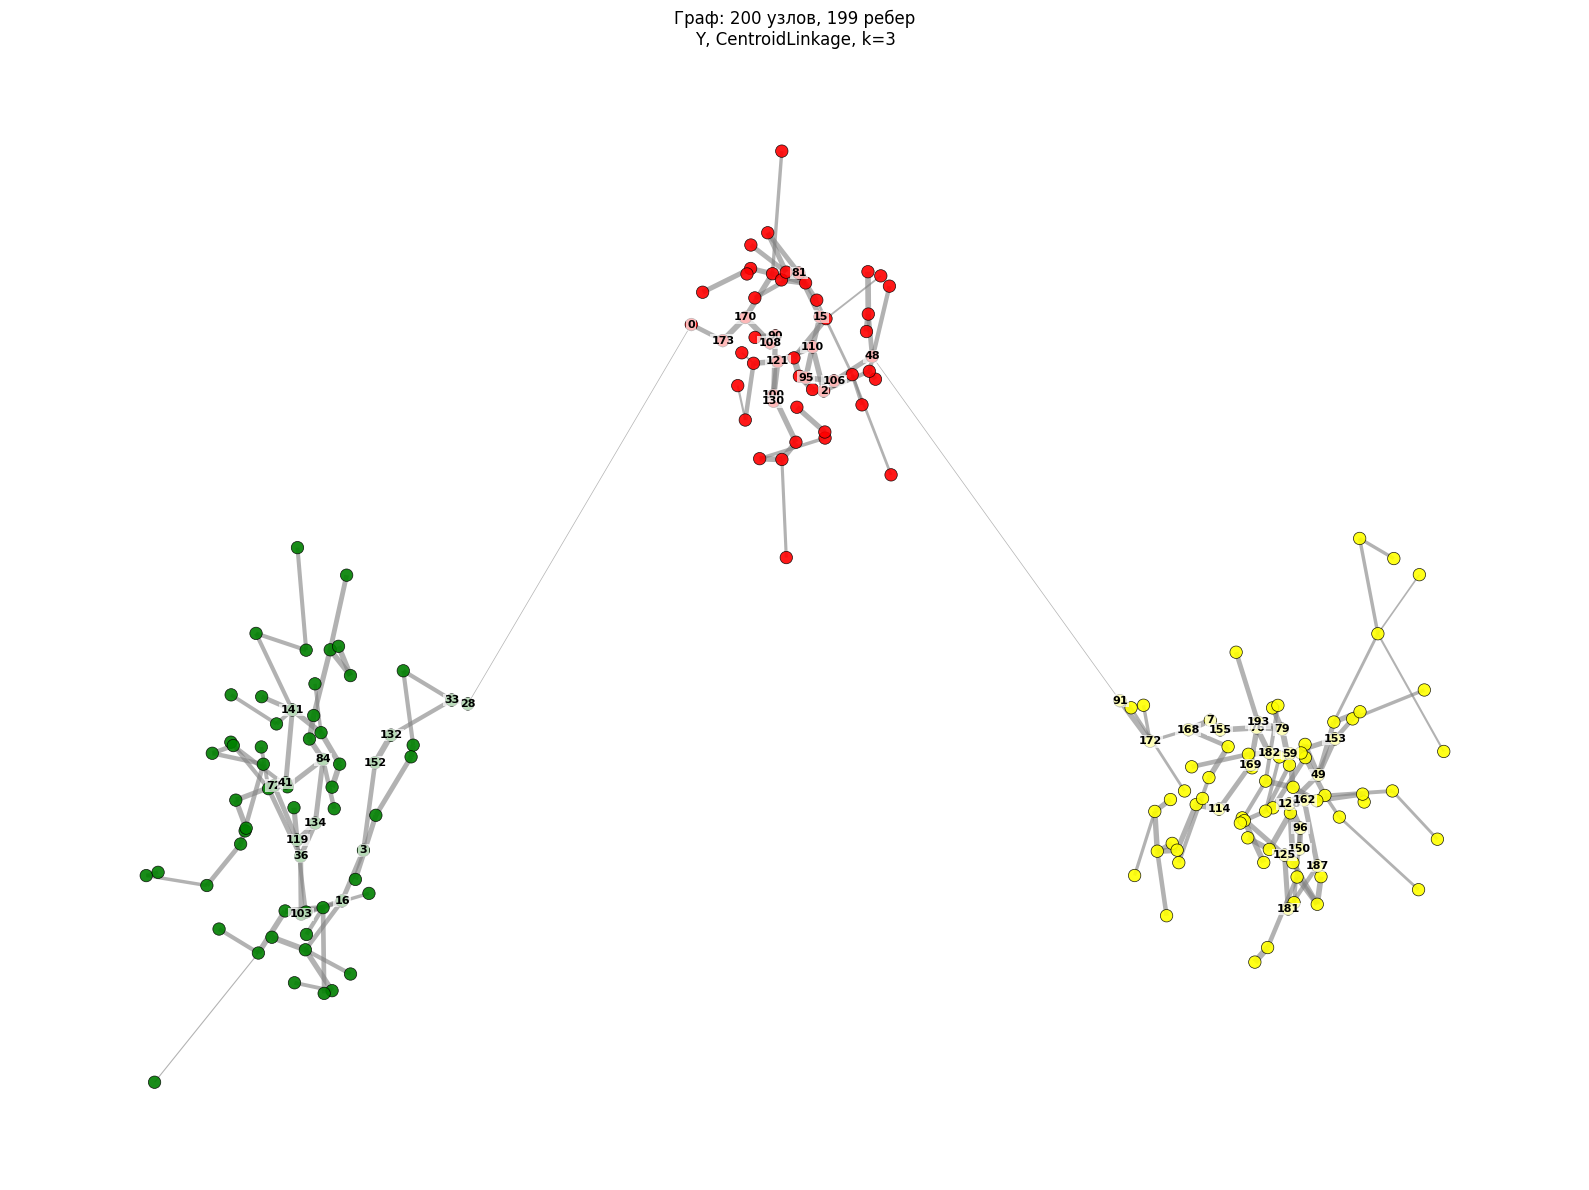

In [ ]:
#@title Кластеризация датасета Y (CentroidLinkage)

CL_labels_k3_y = CentroidLinkage(Y_dist_matrix, n_clusters=3)

draw_weighted_graph(Y_MST_graph, clusters=CL_labels_k3_y, layout='custom', positions=Y_pca, title="Y, CentroidLinkage, k=3")

>

### K-means кластеризация

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 3 2 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 1 3 3 1 1]


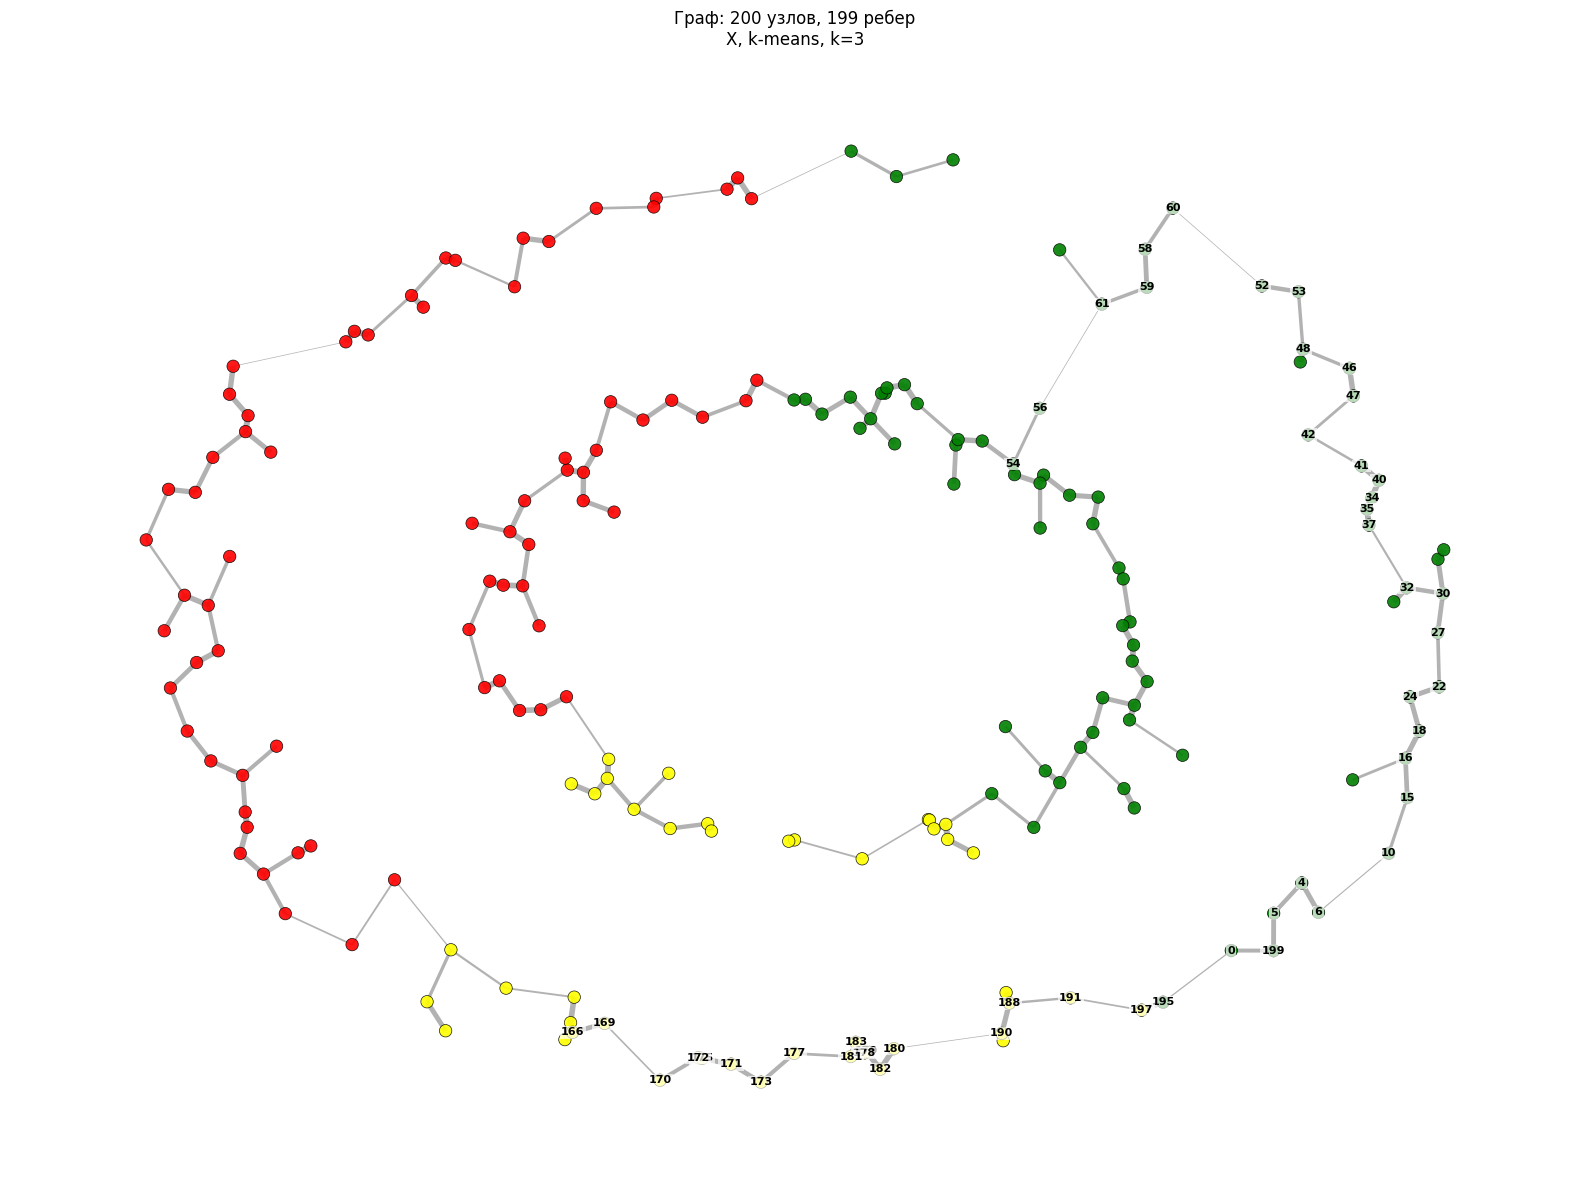

In [ ]:
#@title Кластеризация датасета X

kmeans_labels_k3_x = k_means(X, n_clusters=3)

draw_weighted_graph(X_MST_graph, clusters=kmeans_labels_k3_x, layout='custom', positions=X_pca, title="X, k-means, k=3")

[1 3 1 3 1 2 1 2 1 1 3 2 2 2 2 1 3 3 3 3 2 2 2 2 1 1 2 1 3 3 1 2 1 3 3 1 3
 1 2 3 2 3 3 2 1 1 1 1 1 2 3 2 2 3 3 2 3 3 2 2 1 1 2 2 2 2 3 2 2 2 2 1 3 3
 2 3 2 3 2 2 1 1 2 3 3 2 1 3 3 3 1 2 3 3 1 1 2 2 2 1 1 3 3 3 1 1 1 2 1 3 1
 1 2 3 2 1 2 1 2 3 2 1 2 1 2 2 3 3 2 3 1 2 3 3 3 2 2 3 1 3 2 3 2 3 3 2 2 3
 2 2 2 2 3 2 2 2 3 2 3 3 3 1 2 2 1 1 3 2 2 2 1 2 2 1 3 3 1 3 1 3 1 2 2 3 2
 2 3 2 2 3 1 3 1 2 2 2 2 2 3 1]


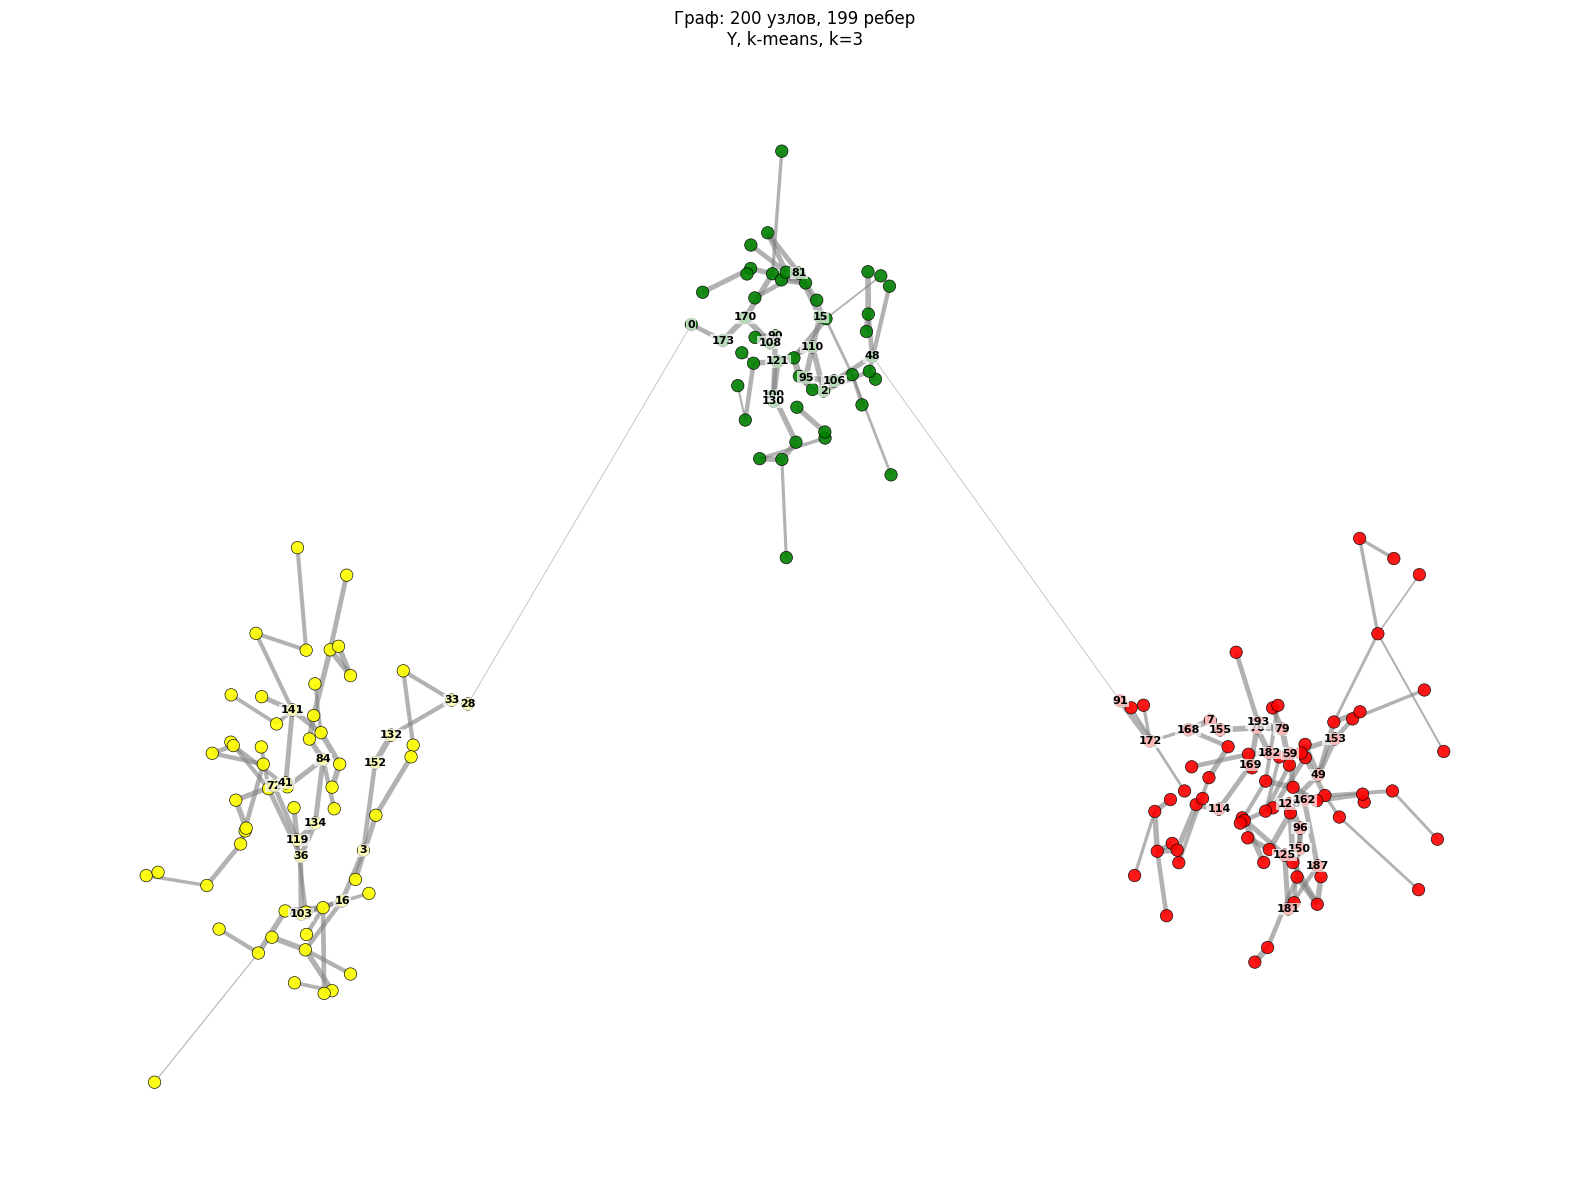

In [ ]:
#@title Кластеризация датасета Y

kmeans_labels_k3_y = k_means(Y, n_clusters=3)

draw_weighted_graph(Y_MST_graph, clusters=kmeans_labels_k3_y, layout='custom', positions=Y_pca, title="Y, k-means, k=3")

### EM-кластеризация

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 3 1 3 3 1 3 3 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


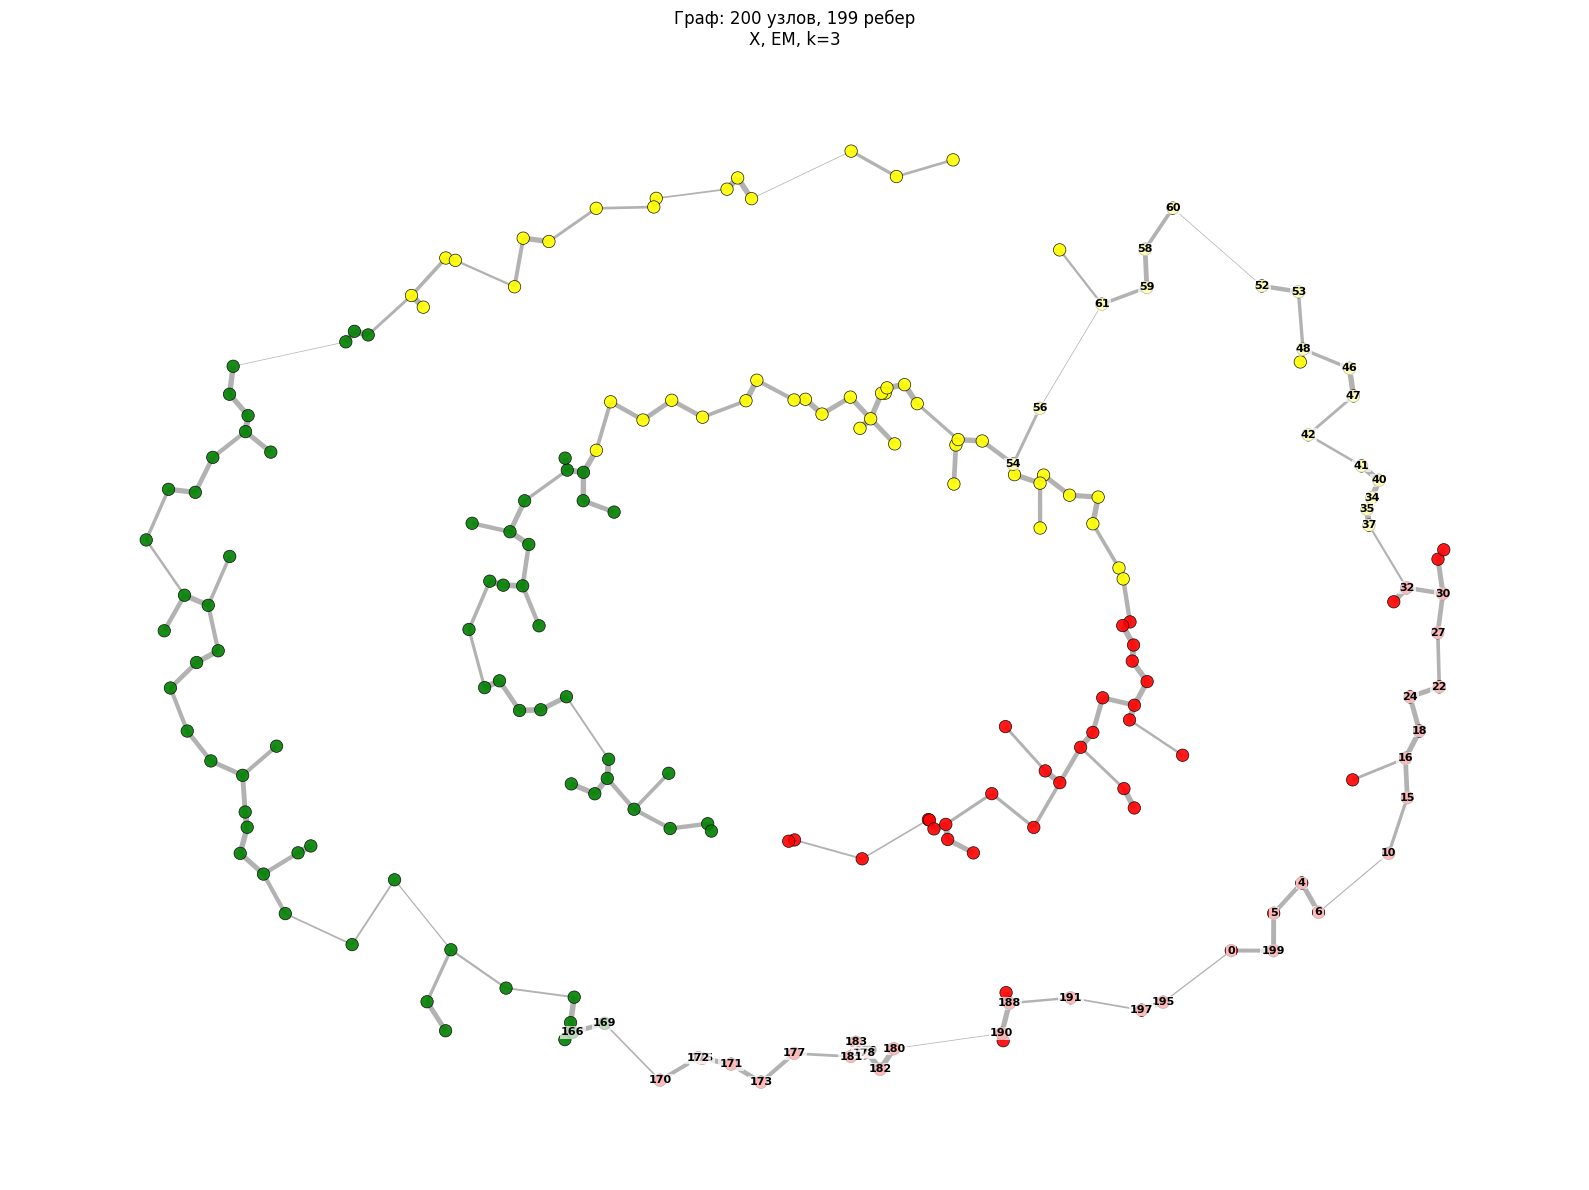

In [ ]:
#@title Кластеризация датасета X

EM_labels_k3_x = EM(X, n_clusters=3)

draw_weighted_graph(X_MST_graph, clusters=EM_labels_k3_x, layout='custom', positions=X_pca, title="X, EM, k=3")

[3 1 3 1 3 2 3 2 3 3 1 2 2 2 2 3 1 1 1 1 2 2 2 2 3 3 2 3 1 1 3 2 3 1 1 3 1
 3 2 1 2 1 1 2 3 3 3 3 3 2 1 2 2 1 1 2 1 1 2 2 3 3 2 2 2 2 1 2 2 2 2 3 1 1
 2 1 2 1 2 2 3 3 2 1 1 2 3 1 1 1 3 2 1 1 3 3 2 2 2 3 3 1 1 1 3 3 3 2 3 1 3
 3 2 1 2 3 2 3 2 1 2 3 2 3 2 2 1 1 2 1 3 2 1 1 1 2 2 1 3 1 2 1 2 1 1 2 2 1
 2 2 2 2 1 2 2 2 1 2 1 1 1 3 2 2 3 3 1 2 2 2 3 2 2 3 1 1 3 1 3 1 3 2 2 1 2
 2 1 2 2 1 3 1 3 2 2 2 2 2 1 3]


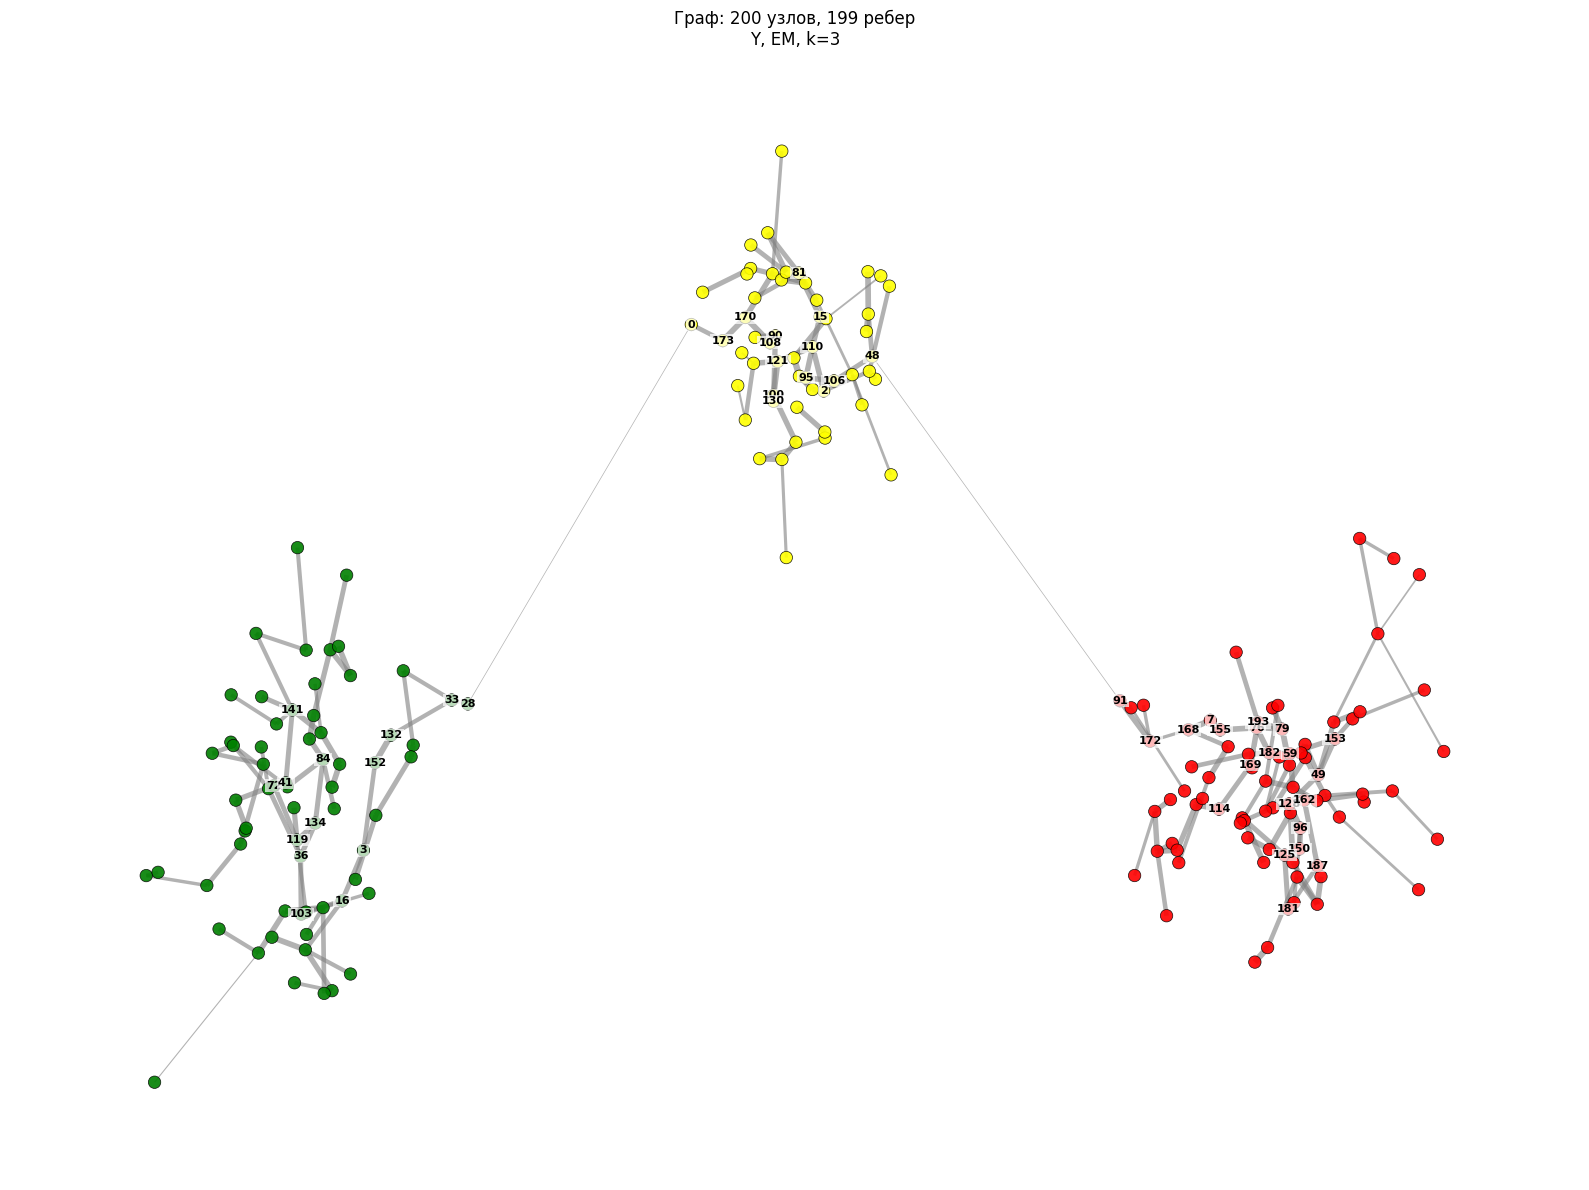

In [ ]:
#@title Кластеризация датасета Y

EM_labels_k3_y = EM(Y, n_clusters=3)

draw_weighted_graph(Y_MST_graph, clusters=EM_labels_k3_y, layout='custom', positions=Y_pca, title="Y, EM, k=3")

### Спектральная кластеризация на основе графовой модели (матрица смежности, нормализованный лапласиан)

[3 1 1 1 3 3 3 1 1 1 3 1 1 3 1 3 3 1 3 1 1 1 3 1 3 1 1 3 1 3 3 3 3 3 3 3 1
 3 1 1 3 3 3 1 1 1 3 3 3 3 1 1 3 3 1 1 1 1 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1
 2 2 2 1 1 1 2 2 2 1 1 2 2 1 1 1 1 2 2 2 2 2 1 1 1 2 2 1 2 1 2 2 2 1 1 2 2
 1 2 2 2 2 1 1 1 1 2 2 2 2 1 2 2 2 2 1 2 2 1 1 2 1 1 2 2 2 2 1 2 2 2 1 2 2
 1 2 1 2 1 2 1 1 1 2 2 2 1 2 2 2 2 1 2 1 1 2 2 2 2 2 1 2 1 2 2 2 2 2 2 2 1
 3 3 1 3 1 3 3 1 1 1 3 1 3 1 3]


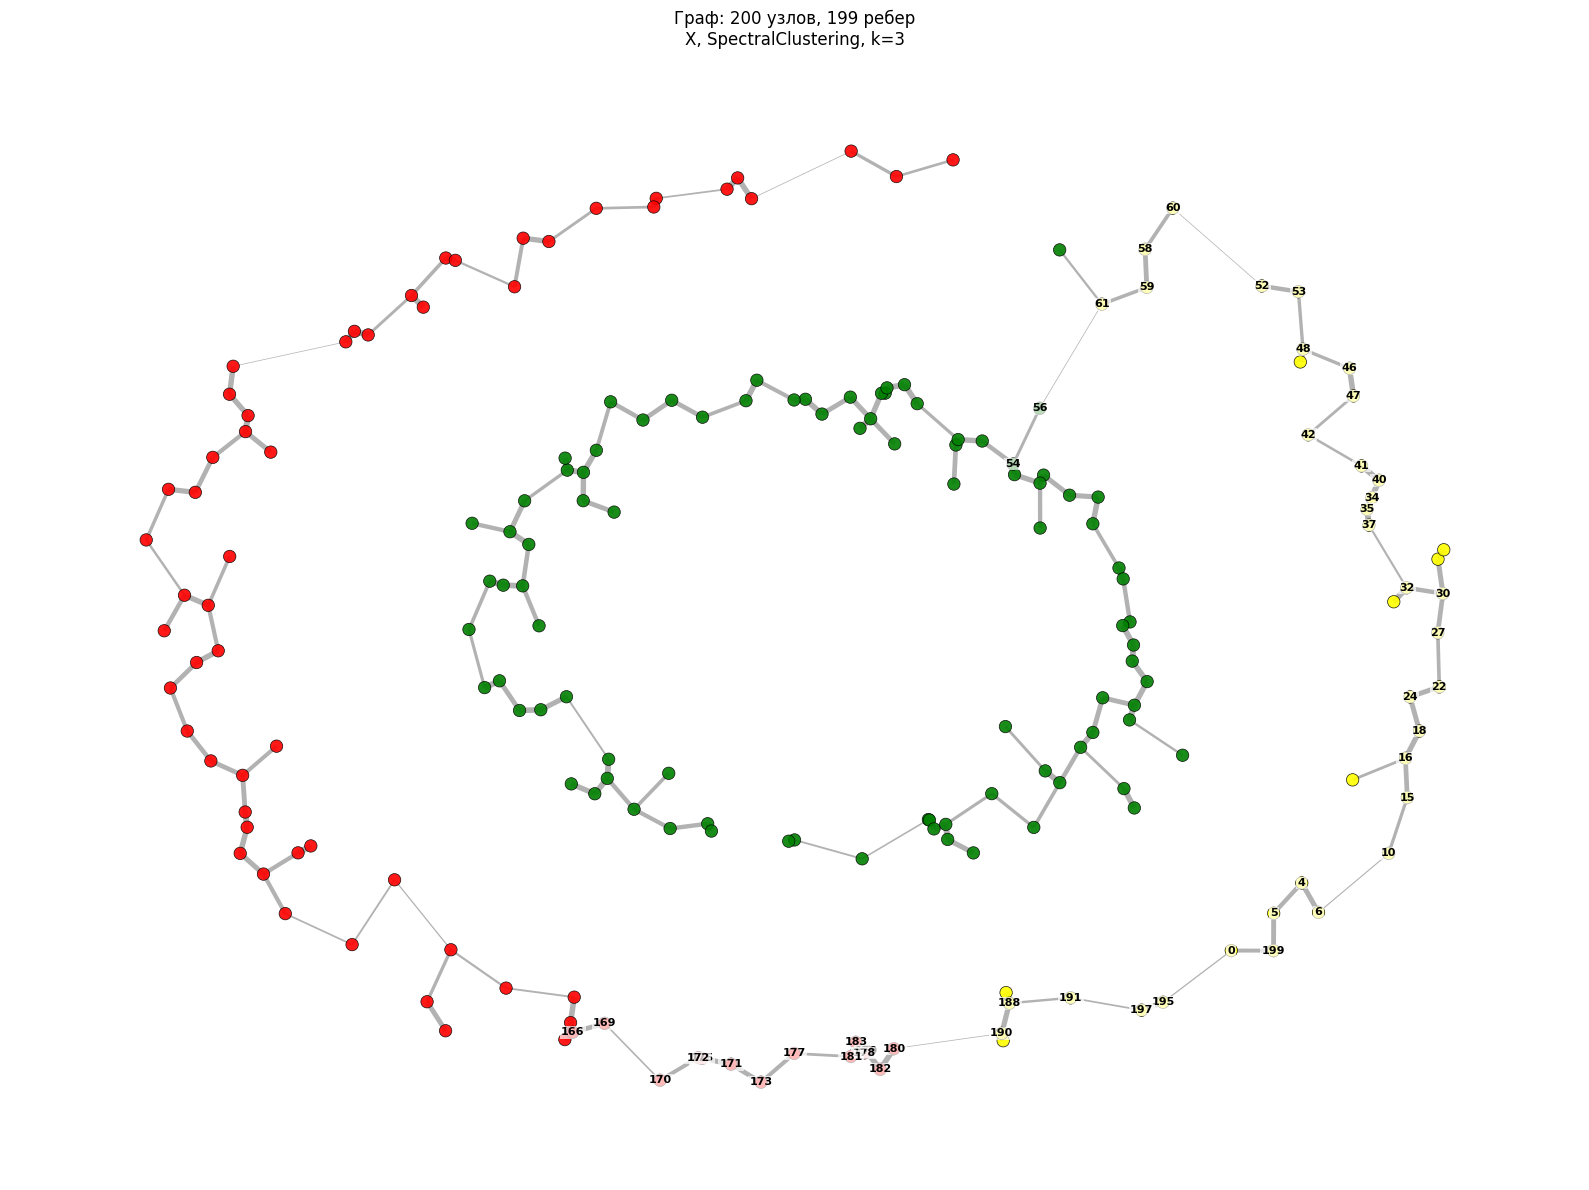

In [ ]:
#@title Кластеризация датасета X

SC_labels_k3_x = SpectralClustering(X_graph_model, n_clusters=3)

draw_weighted_graph(X_MST_graph, clusters=SC_labels_k3_x, layout='custom', positions=X_pca, title="X, SpectralClustering, k=3")

[3 2 3 2 3 1 3 1 3 3 2 1 1 1 1 3 2 2 2 2 1 1 1 1 3 3 1 3 2 2 3 1 3 2 2 3 2
 3 1 2 1 2 2 1 3 3 3 3 3 1 2 1 1 2 2 1 2 2 1 1 3 3 1 1 1 1 2 1 1 1 1 3 2 2
 1 2 1 2 1 1 3 3 1 2 2 1 3 2 2 2 3 1 2 2 3 3 1 1 1 3 3 2 2 2 3 3 3 1 3 2 3
 3 1 2 1 3 1 3 1 2 1 3 1 3 1 1 2 2 1 2 3 1 2 2 2 1 1 2 3 2 1 2 1 2 2 1 1 2
 1 1 1 1 2 1 1 1 2 1 2 2 2 3 1 1 3 3 2 1 1 1 3 1 1 3 2 2 3 2 3 2 3 1 1 2 1
 1 2 1 1 2 3 2 3 1 1 1 1 1 2 3]


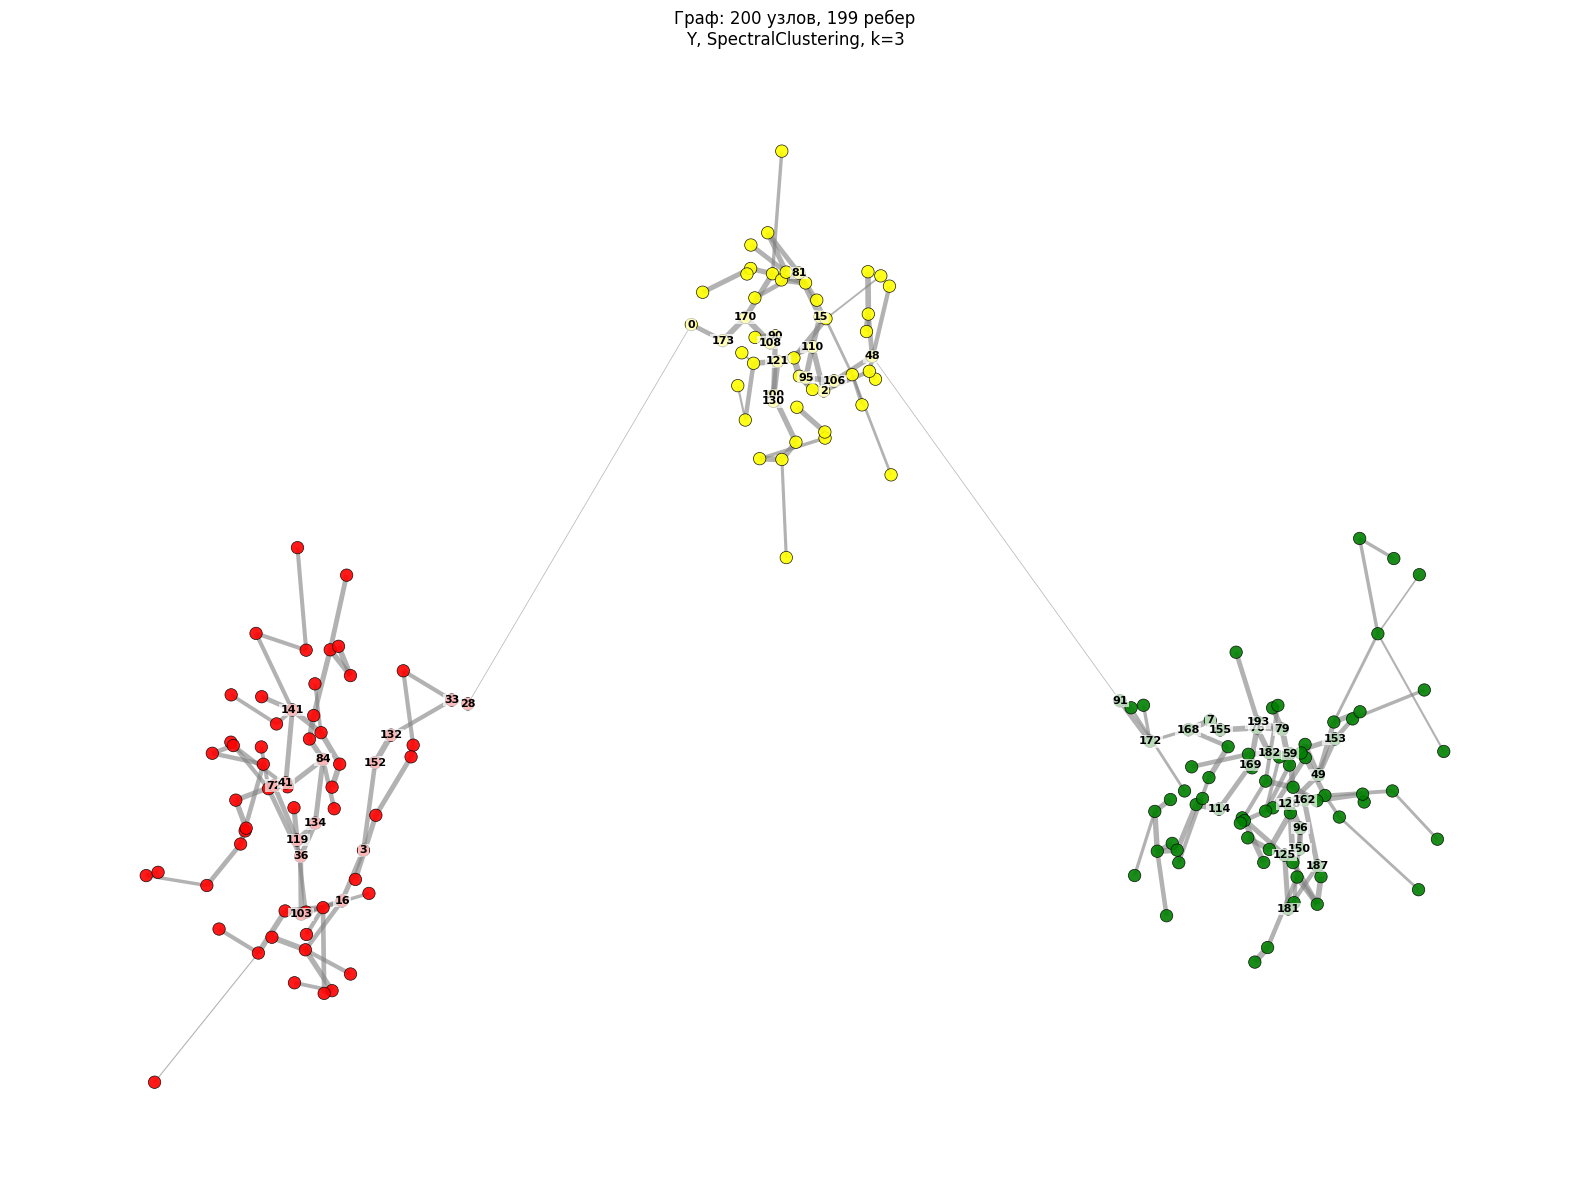

In [ ]:
#@title Кластеризация датасета Y

SC_labels_k3_y = SpectralClustering(Y_graph_model, n_clusters=3)

draw_weighted_graph(Y_MST_graph, clusters=SC_labels_k3_y, layout='custom', positions=Y_pca, title="Y, SpectralClustering, k=3")

### 2.2 Сравнить попарно разбиения, полученные разными методами с помощью RAND индекса

**Общий вывод по полученным результатам кластеризации при $k=3$:**

* Результаты для датасета X делятся на 2 типа: часть алгоритмов кластеризовала X по эллипсам, поделив внешний эллипс на 2 части, другие алгоритмы попытались кластеризовать X по центроидам, что больше подходит для датасета Y

* Результаты для Y везде получились одинаковыми с точностью до перестановки номеров кластеров

In [ ]:
all_labels_k3_x = {
  "SingleLinkage": SL_labels_k3_x,
  "CentroidLinkage": CL_labels_k3_x,
  "k-means": kmeans_labels_k3_x,
  "EM": EM_labels_k3_x,
  "SpectralClustering": SC_labels_k3_x
}

all_labels_k3_y = {
  "SingleLinkage": SL_labels_k3_y,
  "CentroidLinkage": CL_labels_k3_y,
  "k-means": kmeans_labels_k3_y,
  "EM": EM_labels_k3_y,
  "SpectralClustering": SC_labels_k3_y
}

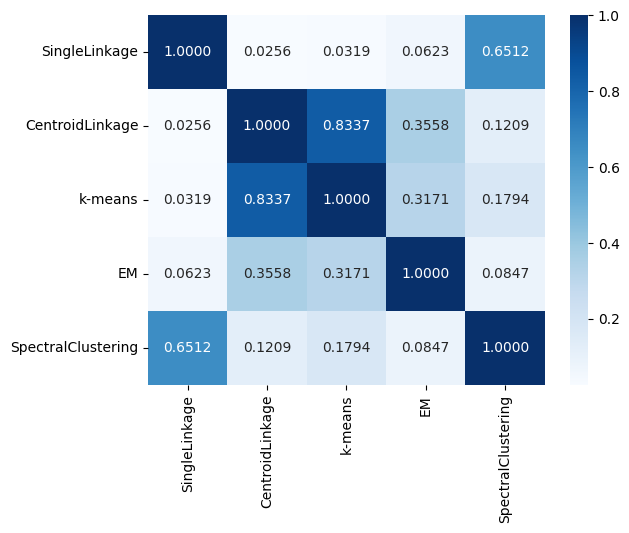

In [ ]:
#@title Сравнение методов кластеризаций через rand индекс (датасет X)

rand_df = compare_rand_matrix(all_labels_k3_x)
sns.heatmap(rand_df, cmap='Blues', annot=True, fmt='.4f')
plt.show()

Как и в случае при 2 кластерах, алгоритмы разбиваются на группы, и результаты для них примерно схожи:

* Spectral Clustering и Single Linkage
* Centroid Linkage, K-means и EM

Отметим, что во второй группе результаты сравнения с EM все же отличаются, но и по картинкам выше можно понять, что результаты кластеризации отличаются (если провести линии, по которым эти кластеры делятся, то для Centroid Linkage и для K-means они будут схожими, но не для EM, хотя идея разбиения та же - через центры кластеров, точки кластера сконцентрированы вокруг центра, поэтому RAND индексы получаются не нулевыми, но и не такими большими)

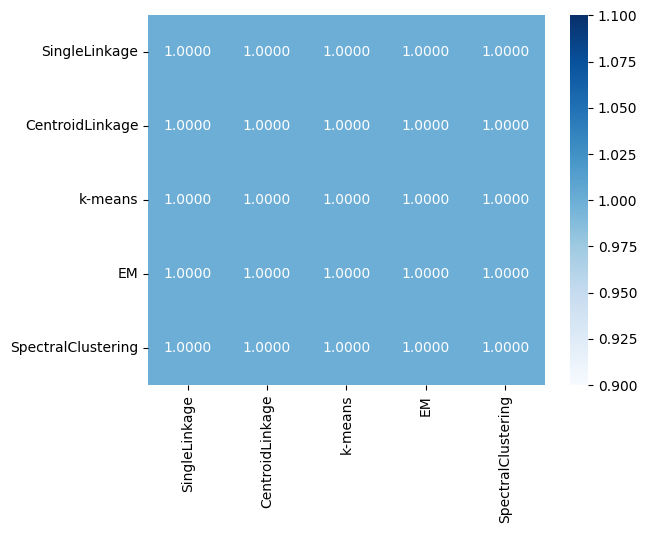

In [ ]:
#@title Сравнение методов кластеризаций через rand индекс (датасет Y)

rand_df = compare_rand_matrix(all_labels_k3_y)
sns.heatmap(rand_df, cmap='Blues', annot=True, fmt='.4f')
plt.show()

Результаты rand индексов показывают что все полученные для Y результаты идентичны с точностью до перестановки номеров кластеров.

### 2.3 Вычислить значение функции модулярности для каждого разбиения на 3 кластера

In [ ]:
#@title Модулярности для датасета X

all_labels = all_hierarchy_clustering(X_dist_matrix, n_clusters=3)

all_Q = calculate_modularity(X_graph_model, all_labels)
df = pd.DataFrame(all_Q.items(), columns=['Method', 'Modularity'])

df

Method  Modularity
0    single   -0.001714
1  complete   -0.001815
2   average   -0.002008
3  centroid   -0.001723
4      ward   -0.001723

In [ ]:
#@title Модулярности для датасета Y

all_labels = all_hierarchy_clustering(Y_dist_matrix, n_clusters=3)

all_Q = calculate_modularity(Y_graph_model, all_labels)
df = pd.DataFrame(all_Q.items(), columns=['Method', 'Modularity'])

df

Method  Modularity
0    single   -0.000457
1  complete   -0.000457
2   average   -0.000457
3  centroid   -0.000457
4      ward   -0.000457

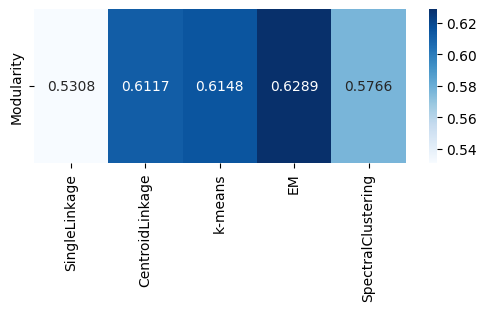

In [ ]:
#@title Сравнение методов кластеризации через модулярность (датасет X)

modularity_df = compare_modularity(all_labels_k3_x, X_graph_model)
plt.figure(figsize=(6, 2))
sns.heatmap(modularity_df, cmap='Blues', annot=True, fmt='.4f')
plt.show()

Значение модулярности, на этот раз, получилось меньше для алгоритмов Single Linkage и Spectral Clustering. Их результаты кластеризации - внутренний эллипс и внешний эллипс, поделенный на 2 части. По значениям модулярности получается, что разбиение двух эллипсов на 3 части, 3 кучных набора точек, лучше.

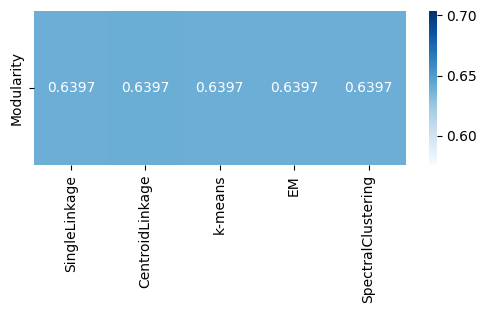

In [ ]:
#@title Сравнение методов кластеризации через модулярность (датасет Y)

modularity_df = compare_modularity(all_labels_k3_y, Y_graph_model)
plt.figure(figsize=(6, 2))
sns.heatmap(modularity_df, cmap='Blues', annot=True, fmt='.4f')
plt.show()

Результаты одинаковы в силу идентичности полученных результатов кластеризации.

## 3. Общий случай

### Предложите (или найдите готовый) способ определения возможного числа кластеров в данных

Данных относительно немного, из PCA (который тоже можно использовать для определения возможного числа кластеров) видно, что кластеров <= 3, поэтому достаточно использовать простой метод по типу метода локтя:

In [ ]:
#@title Elbow Method - метод локтя для определения количества кластеров. Алгоритм - kmeans

def elbow_method(data, max_k=5):
  inertias = []
  k_range = range(1, max_k + 1)

  for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=13213, n_init=10)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

   # Визуализация
  plt.figure(figsize=(6, 4))

  # Elbow
  plt.plot(k_range, inertias, 'bo-')
  plt.xlabel('Number of clusters (k)')
  plt.ylabel('Inertia / BIC')
  plt.title('Elbow Method')
  plt.grid(True)

  plt.tight_layout()
  plt.show()


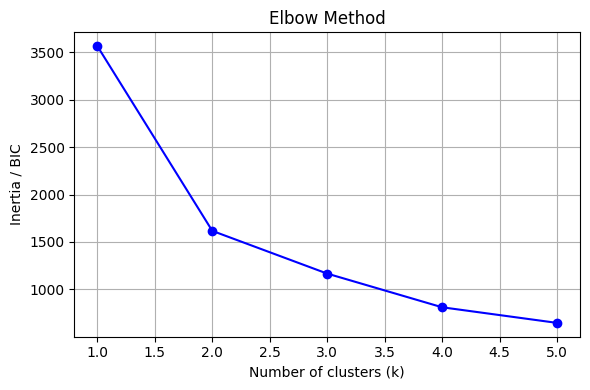

In [ ]:
#@title Метод локтя для датасета X

elbow_method(X)

Для датасета X виден изгиб при $k = 2$ - это потенциальный локоть, показывающий оптимальное число кластеров

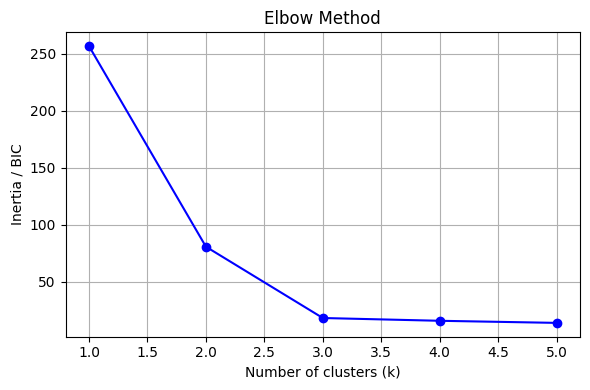

In [ ]:
#@title Метод локтя для датасета Y

elbow_method(Y)

У датасета Y видно 2 локтя - на $k = 2$ и $k = 3$. Для более точного понимания, какое значение лучше, нужно либо строить кластеризации на оба параметра и сравнивать, либо вводить ещё метрику для оценки.

### Предложите какой-либо другой критерий качества кластеризации

Формула **коэффициента силуэта** для точки $x_i$:

$$s(i) = \frac{b(i) - a(i)}{max(a(i), b(i))}, \quad s \in [-1, 1]$$

Здесь:
* $a(i)$ - среднее расстояние до точек своего кластера
* $b(i)$ - минимальное среднее расстояние до другого кластера

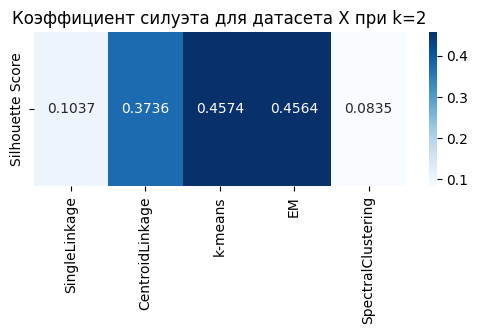

In [ ]:
#@title Сравнение методов кластеризации через коэффициент силуэта (датасет X, 2 кластера)

def compare_silhouette(dict_labels, dist_matrix):
    n_methods = len(dict_labels.keys())
    silhouette_matrix = np.zeros((1, n_methods))

    for i in range(n_methods):
        labels_i = dict_labels[METHODS_NAMES[i]]
        silhouette_matrix[0, i] = silhouette_score(dist_matrix, labels_i, metric='precomputed')

    df = pd.DataFrame(silhouette_matrix,
                    index=['Silhouette Score'],
                    columns=METHODS_NAMES)

    return df


silhouette_df = compare_silhouette(all_labels_k2_x, X_dist_matrix)
plt.figure(figsize=(6, 2))
ax = sns.heatmap(silhouette_df, cmap='Blues', annot=True, fmt='.4f')
ax.set_title('Коэффициент силуэта для датасета X при k=2')
plt.show()

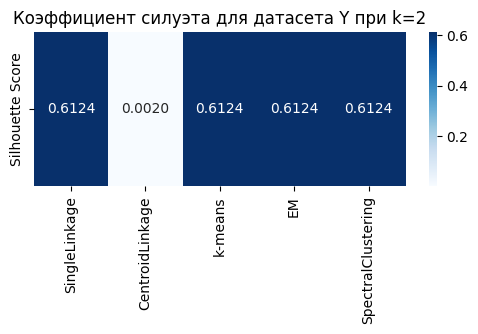

In [ ]:
#@title Сравнение методов кластеризации через коэффициент силуэта (датасет Y, 2 кластера)

silhouette_df = compare_silhouette(all_labels_k2_y, Y_dist_matrix)
plt.figure(figsize=(6, 2))
ax = sns.heatmap(silhouette_df, cmap='Blues', annot=True, fmt='.4f')
ax.set_title('Коэффициент силуэта для датасета Y при k=2')
plt.show()

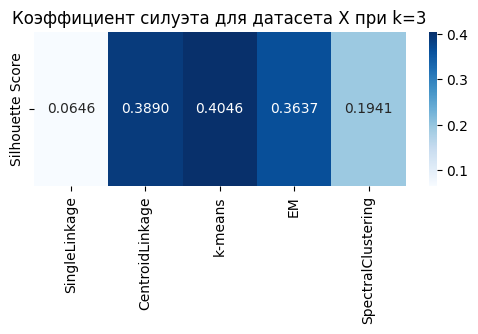

In [ ]:
#@title Сравнение методов кластеризации через коэффициент силуэта (датасет X, 3 кластера)

silhouette_df = compare_silhouette(all_labels_k3_x, X_dist_matrix)
plt.figure(figsize=(6, 2))
ax = sns.heatmap(silhouette_df, cmap='Blues', annot=True, fmt='.4f')
ax.set_title('Коэффициент силуэта для датасета X при k=3')
plt.show()

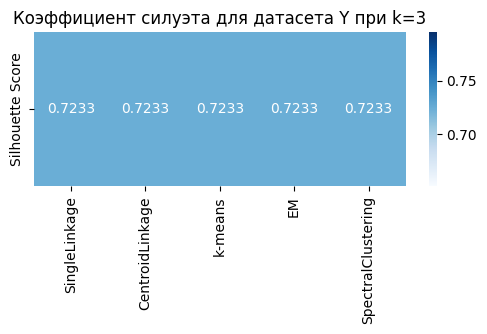

In [ ]:
#@title Сравнение методов кластеризации через коэффициент силуэта (датасет Y, 3 кластера)

silhouette_df = compare_silhouette(all_labels_k3_y, Y_dist_matrix)
plt.figure(figsize=(6, 2))
ax = sns.heatmap(silhouette_df, cmap='Blues', annot=True, fmt='.4f')
ax.set_title('Коэффициент силуэта для датасета Y при k=3')
plt.show()

Объяснение результатов:

* Коэффициент силуэта увеличивается при уменьшении $a(i)$ и увеличении $b(i)$, то есть мы хотим, чтобы внутрикластерные расстояния были маленькими, точки находились близко друг к другу, но чтобы внекластерные расстояния были большими, чтобы кластеры визуально находились далеко друг от друга. В случае с двумя эллипсами все как раз в точности да наоборот: расстояние между эллипсами (кластерами) небольшое, а расстояния между точками внутри одного эллипса могут быть очень большими. Из-за этого коэффициент силуэта принимает большое значение для результатов KMeans и EM, поскольку их результат кластеризации - несколько кучных кластерных структур, наборы близких друг к другу точек.

* Именно по указанным выше причинам коэффициент силуэта идеально подходит для оценки результатов кластеризации датасета Y